In [1]:
import os 
os.chdir('..')

<br>
<h1 style = "font-size:30px; font-weight : bold; color : blue; text-align: center; border-radius: 10px 15px;"> Default of Credit Card: EDA and CatBoost with Feature Engineering </h1>
<br>


# Goals
Perform an Exploratory Data Analysis (EDA) to visualize and understand:
* The distribution of each feature;
* The relationship between the demographic features and the amount of given credit per customer;
* The likelihood of default for each category or 'group of values' in each feature.

Understand how each feature impacts the predicted value using:
* Feature Importance;
* SHAP.

# <a id='0'>Content</a>
​
- <a href='#1'>Dataset Information</a>  
- <a href='#2'>Importing Packages and First Look at the Data</a>  
- <a href='#3'>Exploratory Data Analysis</a>  
    - <a href='#31'>Demographic Features</a>  
    - <a href='#32'>Given Credit and Repayment Status</a>
    - <a href='#33'>Amount of Bill Statement and Previous Payment</a>
- <a href='#4'>Creating and Evaluating Models</a>
    - <a href='#41'>Random Forest</a> 
    - <a href='#42'>CatBoost</a>
    - <a href='#43'>CatBoost w/added features</a> 
    - <a href='#44'>Feature Importance and SHAP Plot</a> 
- <a href='#5'>References</a>

# <a id="1">Dataset Information</a> 

This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

### Content

There are 25 variables:

- ID: ID of each client
- LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary = credit)
- SEX: Gender (1=male, 2=female)
- EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- MARRIAGE: Marital status (1=married, 2=single, 3=others)
- AGE: Age in years
- PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
- PAY_2: Repayment status in August, 2005 (scale same as above)
- PAY_3: Repayment status in July, 2005 (scale same as above)
- PAY_4: Repayment status in June, 2005 (scale same as above)
- PAY_5: Repayment status in May, 2005 (scale same as above)
- PAY_6: Repayment status in April, 2005 (scale same as above)
- BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
- BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
- BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
- BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
- BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
- BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
- PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
- PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
- PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
- PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
- PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
- PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
- default.payment.next.month: Default payment (1=yes, 0=no)

### Additional Information [(source)](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset/discussion/34608)

- Education (0, 4, 5, 6 = others. I'll be opting to group '0','5' and '6' together)
- Marital status (3 = divorce; 0=others)
- PAY_AMTX: (-2 = No consumption; -1 = Paid in full; 0 = The use of revolving credit)

In [2]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from catboost import Pool
import plotly.express as px
import plotly.graph_objects as go

import shap
from typing import final
from IPython.display import Image

PLOT_DIR : final = 'artifact/eda/figures'

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('artifact/Stage00_data_ingestion/raw_data/UCI_Credit_Card.csv')

Changing ‘PAY_0 to PAY_1’ to keep in the same pattern as the other ‘September’ features . Changing Default's name to make it shorter.

In [4]:
df.rename(columns = {'PAY_0':'PAY_1', 'default.payment.next.month':'Default'}, inplace = True)
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         30000 non-null  int64  
 1   LIMIT_BAL  30000 non-null  float64
 2   SEX        30000 non-null  int64  
 3   EDUCATION  30000 non-null  int64  
 4   MARRIAGE   30000 non-null  int64  
 5   AGE        30000 non-null  int64  
 6   PAY_1      30000 non-null  int64  
 7   PAY_2      30000 non-null  int64  
 8   PAY_3      30000 non-null  int64  
 9   PAY_4      30000 non-null  int64  
 10  PAY_5      30000 non-null  int64  
 11  PAY_6      30000 non-null  int64  
 12  BILL_AMT1  30000 non-null  float64
 13  BILL_AMT2  30000 non-null  float64
 14  BILL_AMT3  30000 non-null  float64
 15  BILL_AMT4  30000 non-null  float64
 16  BILL_AMT5  30000 non-null  float64
 17  BILL_AMT6  30000 non-null  float64
 18  PAY_AMT1   30000 non-null  float64
 19  PAY_AMT2   30000 non-null  float64
 20  PAY_AM

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_1,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


At first, without looking at [this thread](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset/discussion/34608) to provide additional information about the dataset, some minimum values stood out for not matching the descriptions of their features (Education = 0, Marriage = 0 and PAY_X features = -2). For ‘Education’ and ‘Marriage’, the zero values could have been used to replace missing values. The ‘-2’ on PAY_X didn’t have an explanation, at least without a deep look on the data, but it should mean something positive, similar to ‘-1’ (‘-2’, ‘-1’ and ‘0’ were associated with lower chance of default). 

The negative values on BILL_AMTX also seemed odd, but it could simply mean that the customers paid more than their actual debts. A lower probability of default is expected for those customers.

# <a id="3">Exploratory Data Analysis</a> 

## Default 

In [7]:
df.isnull().sum()

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Default      0
dtype: int64

In [8]:
os.makedirs(PLOT_DIR, exist_ok=True)

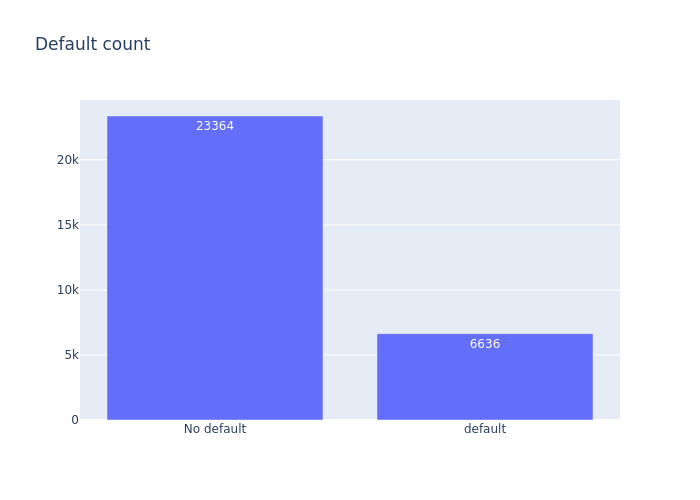

In [9]:
plot_path = os.path.join(PLOT_DIR, 'default_value_count.png')
data_to_plot = df.groupby(by= ["Default"]).size().reset_index(name='count')
data_to_plot["Default"].replace({0:'No default', 1:'default'}, inplace=True)
fig = go.Figure()
fig.add_bar(x=data_to_plot.Default, y=data_to_plot['count'] , text=data_to_plot['count'], textposition='auto' )
fig.update_layout(title_text='Default count')
fig.write_image(plot_path)

Image(plot_path)

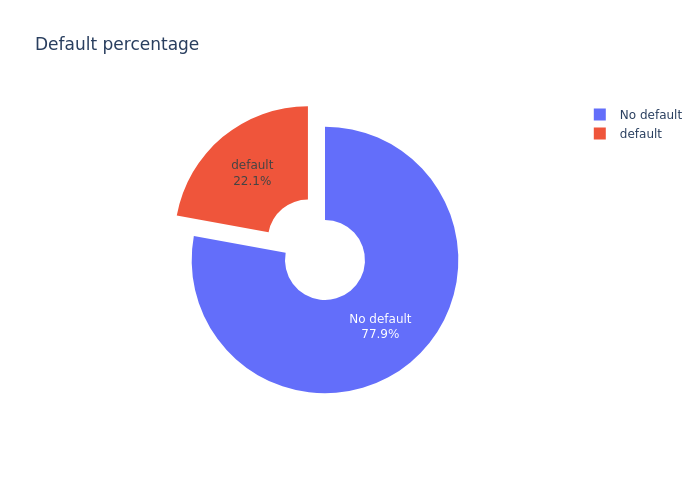

In [10]:
plot_path = os.path.join(PLOT_DIR, 'default_percentt.png')
data_to_plot = df['Default'].map({0:'No default', 1:'default'}).value_counts(normalize=True)
fig = go.Figure()

fig.add_pie(labels=data_to_plot.index, values=data_to_plot.values, textinfo='label+percent', textposition='inside', hole=.3 , pull=[0, 0.2])
fig.update_layout(title_text='Default percentage')
fig.write_image(plot_path)

Image(plot_path)

## Sex distribution

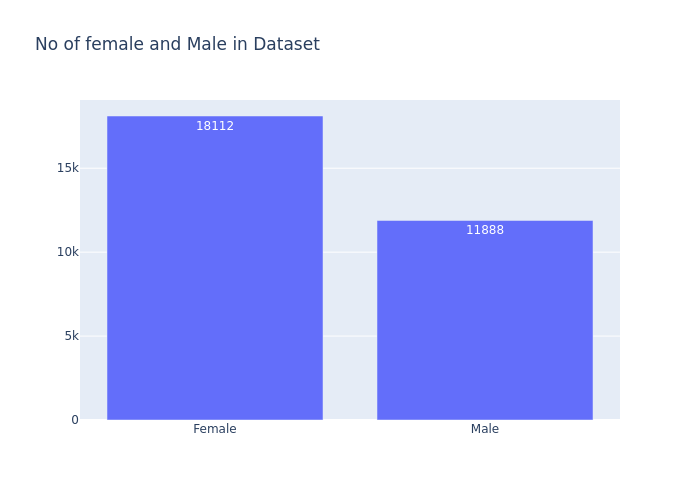

In [11]:
plot_path = os.path.join(PLOT_DIR , "sex_counbt.png")

data_to_plot = df["SEX"].map({1 : "Male" , 2 : "Female" }).value_counts()
fig = go.Figure()

fig.add_bar(x=data_to_plot.index, y=data_to_plot.values, text=data_to_plot.values, textposition='auto')

fig.update_layout(title_text= " No of female and Male in Dataset")

fig.write_image(plot_path)

Image(plot_path)

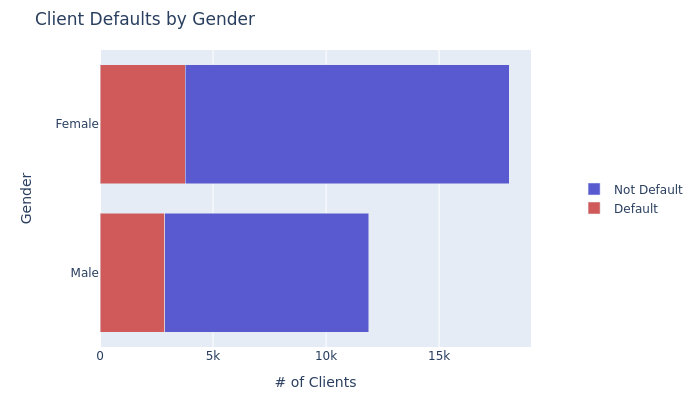

In [12]:

plot_title = "Client Defaults by Gender"
plot_path = os.path.join(PLOT_DIR , f"{plot_title.replace(' ', '_')}.png")

count_df = df.groupby(['SEX', 'Default']).size().reset_index(name='count')
count_df['SEX'] = count_df['SEX'].replace({1: 'Male', 2: 'Female'})

# create a horizontal bar chart
fig = go.Figure()
fig.add_trace(go.Bar(
    x=count_df[count_df['Default']==1]['count'],
    y=count_df[count_df['Default']==1]['SEX'],
    name='Default',
    orientation='h',
    marker=dict(color="rgb(208, 90, 90)")
))
fig.add_trace(go.Bar(
    x=count_df[count_df['Default']==0]['count'],
    y=count_df[count_df['Default']==0]['SEX'],
    name='Not Default',
    orientation='h',
    marker=dict(color="rgb(90, 90, 208)")
))

# update the layout
fig.update_layout(
    title="Client Defaults by Gender",
    xaxis_title="# of Clients",
    yaxis_title="Gender",
    margin=dict(l=100, r=100, t=50, b=50),
    height=400,
    barmode='stack',
    showlegend=True,
    legend=dict(x=1.1, y=0.5),
)

# show the plot
fig.write_image(plot_path)

Image(plot_path)

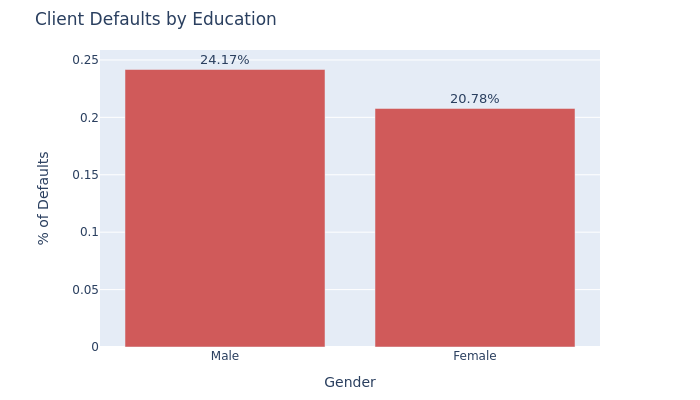

In [13]:
plot_title = "Client Defaults by Education"
plot_path = os.path.join(PLOT_DIR , f"{plot_title.replace(' ', '_')}.png")
# calculate the percentage of defaults by sex
default_pct = df.groupby('SEX')['Default'].mean().reset_index()
default_pct['SEX'] = default_pct['SEX'].replace({1: 'Male', 2: 'Female'})

# create a bar chart
fig = go.Figure(go.Bar(
    x=default_pct['SEX'],
    y=default_pct['Default'],
    marker_color='rgb(208, 90, 90)',
))

# update the layout
fig.update_layout(
    title=plot_title,
    xaxis_title="Gender",
    yaxis_title="% of Defaults",
    margin=dict(l=100, r=100, t=50, b=50),
    height=400,
    showlegend=False,
)

# add annotations
for i, row in default_pct.iterrows():
    fig.add_annotation(
        x=row['SEX'],
        y=row['Default'],
        text="{:.2%}".format(row['Default']),
        font=dict(size=13),
        showarrow=False,
        yshift=10,
    )

# show the plot
fig.write_image(plot_path)

Image(plot_path)

Our dataset has more female clients than male clients. Upon initial analysis, it appears that male clients have a slightly higher likelihood of defaulting than female clients. Later on, we will further investigate this by comparing clients of the same education and marital status, stratified by gender.

## Education

As we saw on the descriptive statistics (df.describe), there is a minimum value of 0 in 'Education', which didn't match the possible values for this feature according to the original dataset information. The additional information puts 4 values (0, 4, 5, 6) in the same category ('others'). 

The values '5' and '6' are both originally labelled as 'unknown' and we don't have a defined label for '0'. Maybe we can put them all together in the same category. But first, we will leave it as it is for now and check how many samples there are in each category and what is their percentage of Default.

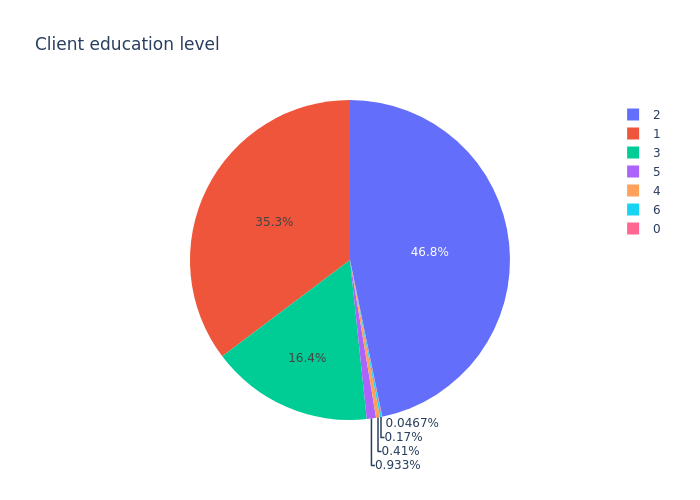

In [14]:
plot_title = "Client education level"
plot_path = os.path.join(PLOT_DIR , f"{plot_title.replace(' ', '_')}.png")

fig = go.Figure()

fig.add_pie(labels=df['EDUCATION'].value_counts().index, values=df['EDUCATION'].value_counts().values)
fig.update_layout(title_text=plot_title)

fig.write_image(plot_path)

Image(plot_path)



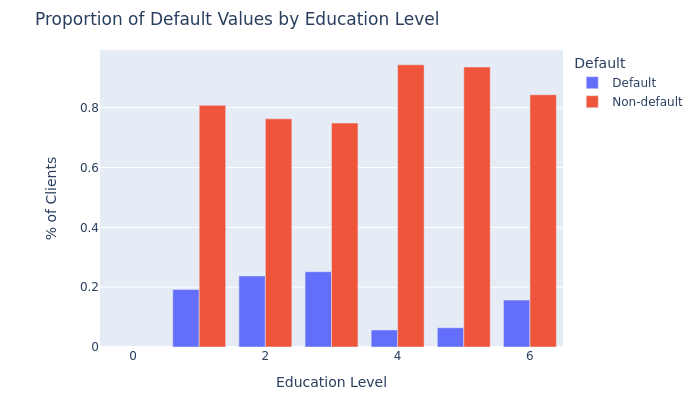

In [15]:
plot_title = 'Proportion of Default Values by Education Level'
plot_path = os.path.join(PLOT_DIR , f"{plot_title.replace(' ', '_')}.png")
# calculate the proportion of default values for each education level
default_prop = df.groupby(['EDUCATION', 'Default']).size().unstack().reset_index()
default_prop['Total'] = default_prop[0] + default_prop[1]
default_prop[0] /= default_prop['Total']
default_prop[1] /= default_prop['Total']
default_prop = default_prop.rename(columns={0: 'Non-default', 1: 'Default'})

# create the bar chart
fig = px.bar(default_prop, x='EDUCATION', y=['Default', 'Non-default'], barmode='group')

# update the layout
fig.update_layout(
    title=plot_title,
    xaxis_title='Education Level',
    yaxis_title='% of Clients',
    margin=dict(l=100, r=100, t=50, b=50),
    height=400,
    legend_title='Default',
)

fig.write_image(plot_path)

Image(plot_path)

The number of individuals belonging to the 'unknown' categories (0, 5, 6) is relatively small in comparison to the 'well defined' labels (1, 2, and 3). Although their default probabilities are not identical, they are all lower than those found in the 'well defined' labels. Therefore, we will group the 'unknown' categories together as one label for further analysis.

<span style="color:red"> Data manipulation </span>

In [16]:
df.loc[:,'EDUCATION'] = df.loc[:,'EDUCATION'].replace(0,5)
df.loc[:,'EDUCATION'] = df.loc[:,'EDUCATION'].replace(6,5)

In [17]:
df['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      345
4      123
Name: EDUCATION, dtype: int64

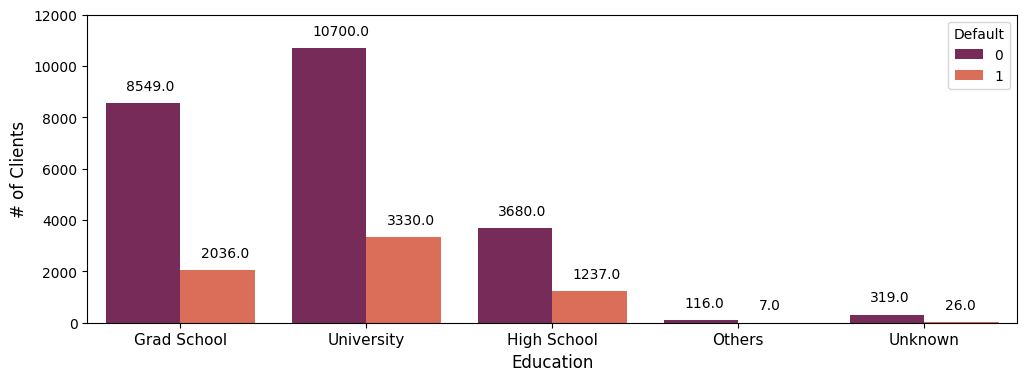

In [18]:
plt.figure(figsize=(12,4))

ax = sns.countplot(data = df, x = 'EDUCATION', hue="Default", palette = 'rocket')

plt.xlabel("Education", fontsize= 12)
plt.ylabel("# of Clients", fontsize= 12)
plt.ylim(0,12000)
plt.xticks([0,1,2,3,4],['Grad School','University','High School','Others','Unknown'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.11, p.get_height()+500))

plt.show()


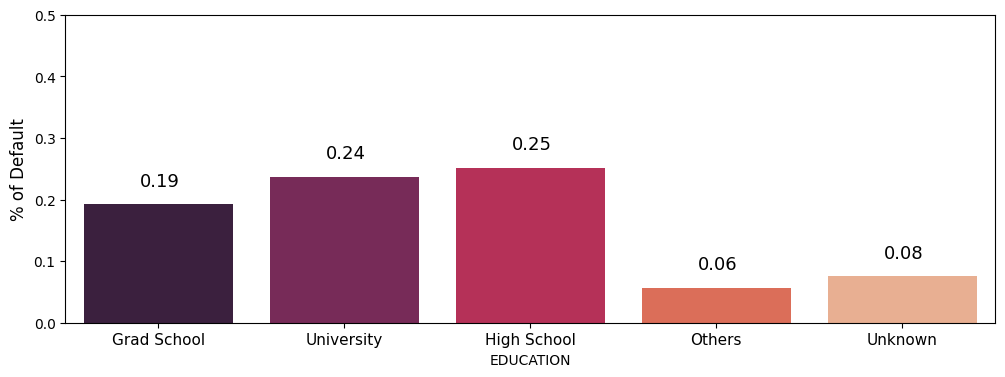

In [19]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "EDUCATION", y = "Default", data = df, palette = 'rocket', ci = None)

plt.ylabel("% of Default", fontsize= 12)
plt.ylim(0,0.5)
plt.xticks([0,1,2,3,4],['Grad School','University','High School','Others','Unknown'], fontsize = 11)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.30, p.get_height()+0.03),fontsize=13)

plt.show()

In our dataset, "University" is the most common educational level, followed by "Grad School," "High School," "Unknown," and "Others."

When only the first three levels are taken into account, it appears that a greater education correlates with a decreased risk of default. Yet, the likelihood of "Unknown" and "Others" (which we would assume denotes a level below high school) is substantially lower.

## Marital Status

In [20]:
df['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [21]:
df['Default'].groupby(df['MARRIAGE']).value_counts(normalize = True)

MARRIAGE  Default
0         0          0.907407
          1          0.092593
1         0          0.765283
          1          0.234717
2         0          0.790717
          1          0.209283
3         0          0.739938
          1          0.260062
Name: Default, dtype: float64

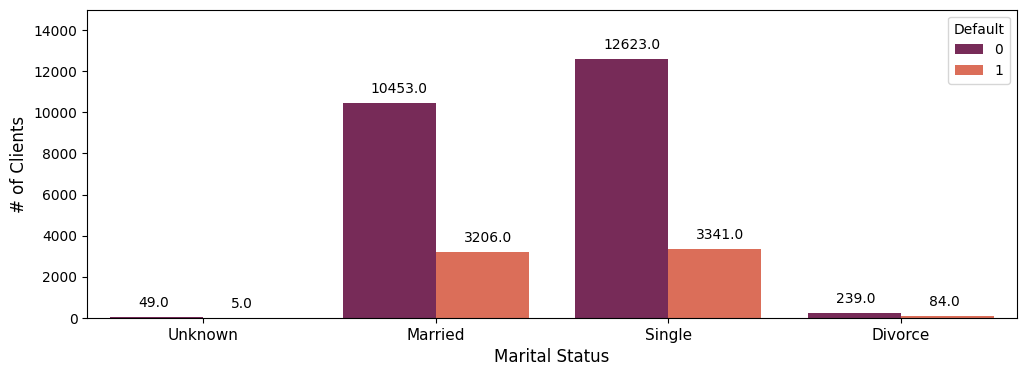

In [22]:
plt.figure(figsize=(12,4))

ax = sns.countplot(data = df, x = 'MARRIAGE', hue="Default", palette = 'rocket')

plt.xlabel("Marital Status", fontsize= 12)
plt.ylabel("# of Clients", fontsize= 12)
plt.ylim(0,15000)
plt.xticks([0,1,2,3],['Unknown', 'Married', 'Single', 'Divorce'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.12, p.get_height()+500))

plt.show()

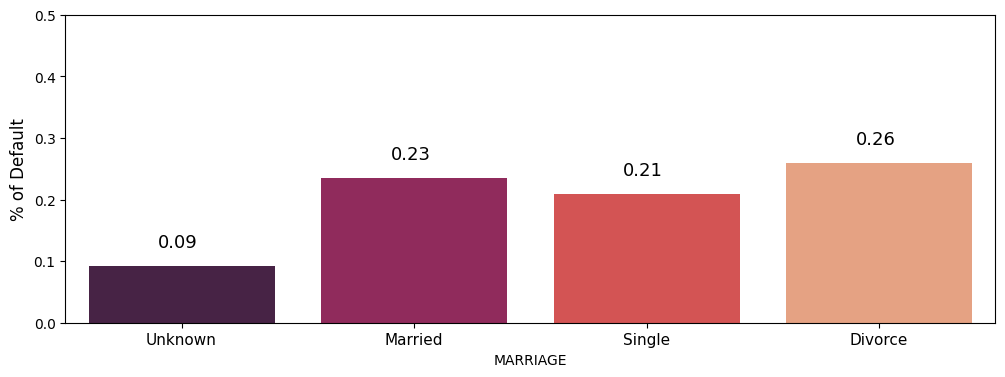

In [23]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "MARRIAGE", y = "Default", data = df, palette = 'rocket', ci = None)

plt.ylabel("% of Default", fontsize= 12)
plt.ylim(0,0.5)
plt.xticks([0,1,2,3],['Unknown', 'Married', 'Single', 'Divorce'], fontsize = 11)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.30, p.get_height()+0.03),fontsize=13)

plt.show()

As would be assumed, the majority of persons fall into the "Married" or "Single" categories.

Once more, the likelihood of default is lower in the "Unknown" group. Of the remaining group, those who are unmarried have a somewhat reduced likelihood of defaulting, whereas those who have had a divorce have a higher likelihood.

## Sex + Education/Marital Status

We've seen that men apparently are more likely to default than women. We can be a little more sure by comparing them considering similar education levels and marital status.

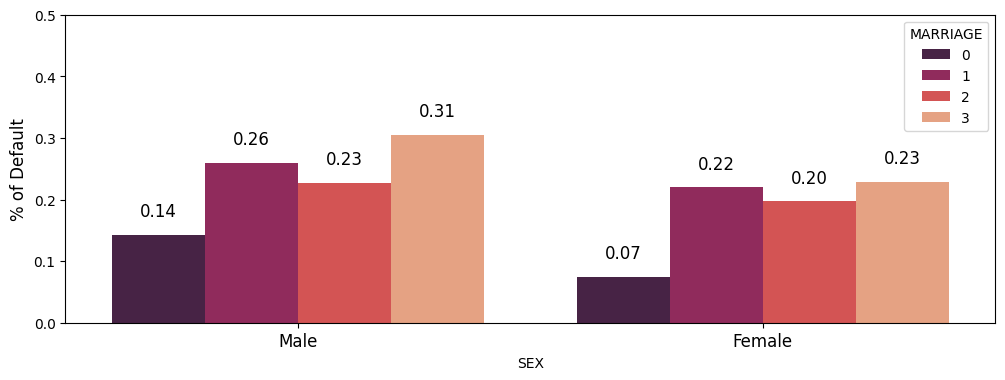

In [24]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "SEX", y = "Default", hue = "MARRIAGE", data = df, palette = 'rocket', ci = None)

plt.ylabel("% of Default", fontsize= 12)
plt.ylim(0,0.5)
plt.xticks([0,1],['Male', 'Female'], fontsize = 12)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.06, p.get_height()+0.03),fontsize=12)

plt.show()

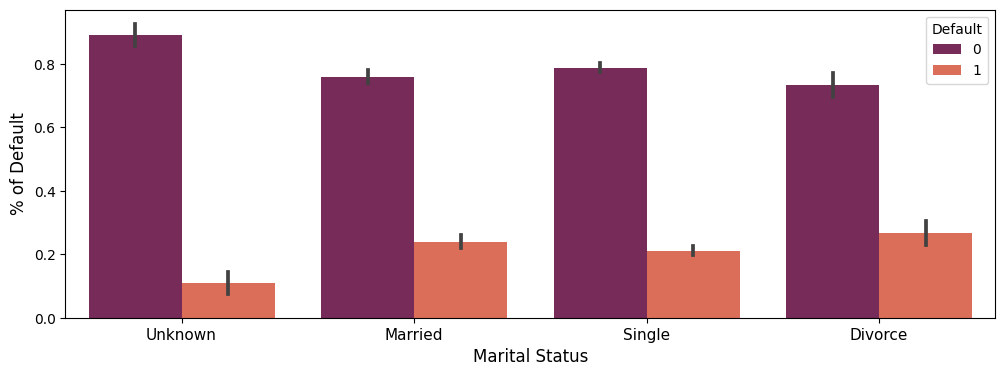

In [25]:
plot_title = 'Proportion of Default Values by Marital Status'
plot_path = os.path.join(PLOT_DIR , f"{plot_title.replace(' ', '_')}.png")
plt.figure(figsize=(12,4))
data_tp_plot = df.groupby(by=['MARRIAGE', 'SEX'])['Default'].value_counts(normalize = True)

sns.barplot(x = data_tp_plot.index.get_level_values(0), y = data_tp_plot.values, hue = data_tp_plot.index.get_level_values(2), palette = 'rocket')
plt.xlabel("Marital Status", fontsize= 12)
plt.ylabel("% of Default", fontsize= 12)

plt.xticks([0,1,2,3],['Unknown', 'Married', 'Single', 'Divorce'], fontsize = 11)

plt.savefig(plot_path)


In every single comparison, the probability of default was higher for men.

## Age 

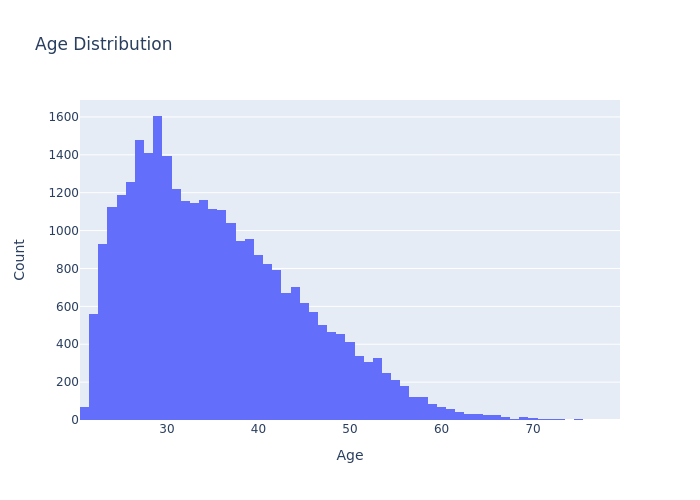

In [26]:
plot_title = "Age Distribution"

plot_path = os.path.join(PLOT_DIR , f"{plot_title.replace(' ', '_')}.png")

fig = go.Figure()

fig.add_histogram(x=df['AGE'])

fig.update_layout( title=plot_title, xaxis_title='Age', yaxis_title='Count')

fig.write_image(plot_path)

Image(plot_path)

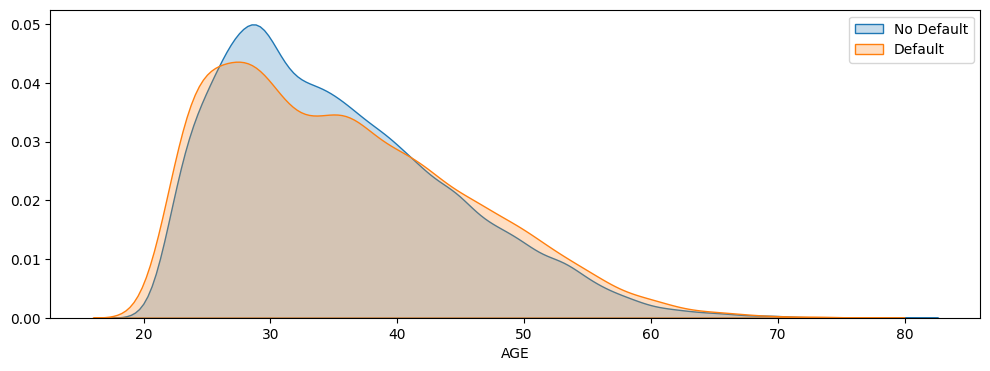

In [27]:
plt.figure(figsize=(12,4))

sns.kdeplot(df.loc[(df['Default'] == 0), 'AGE'], label = 'No Default', shade = True)
sns.kdeplot(df.loc[(df['Default'] == 1), 'AGE'], label = 'Default', shade = True)
plt.ylabel('')
plt.legend()
plt.show()

Most of the participants in our sample are between the ages of 25 and 40. Also, there is a perception that around that age, the likelihood of default is slightly reduced, but we could break our dataset into age groups and look at the proportion of default in each to be certain.

<span style="color:red"> Data manipulation </span>

In [28]:
df['AgeBin'] = pd.cut(df['AGE'],[20, 25, 30, 35, 40, 50, 60, 80])
df['AgeBin'].value_counts()

(25, 30]    7142
(40, 50]    6005
(30, 35]    5796
(35, 40]    4917
(20, 25]    3871
(50, 60]    1997
(60, 80]     272
Name: AgeBin, dtype: int64

In [29]:
df['Default'].groupby(df['AgeBin']).value_counts(normalize = True)

AgeBin    Default
(20, 25]  0          0.733402
          1          0.266598
(25, 30]  0          0.798516
          1          0.201484
(30, 35]  0          0.805728
          1          0.194272
(35, 40]  0          0.783811
          1          0.216189
(40, 50]  0          0.767027
          1          0.232973
(50, 60]  0          0.747621
          1          0.252379
(60, 80]  0          0.731618
          1          0.268382
Name: Default, dtype: float64

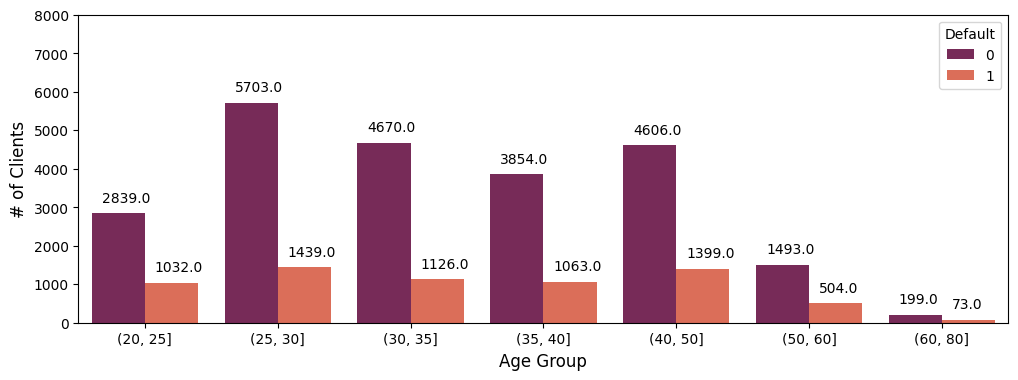

In [30]:
plt.figure(figsize=(12,4))
df['AgeBin'] = df['AgeBin'].astype('str')
AgeBin_order = ['(20, 25]', '(25, 30]', '(30, 35]', '(35, 40]', '(40, 50]', '(50, 60]', '(60, 80]']

ax = sns.countplot(data = df, x = 'AgeBin', hue="Default", palette = 'rocket', order = AgeBin_order)

plt.xlabel("Age Group", fontsize= 12)
plt.ylabel("# of Clients", fontsize= 12)
plt.ylim(0,8000)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.075, p.get_height()+300))

plt.show()

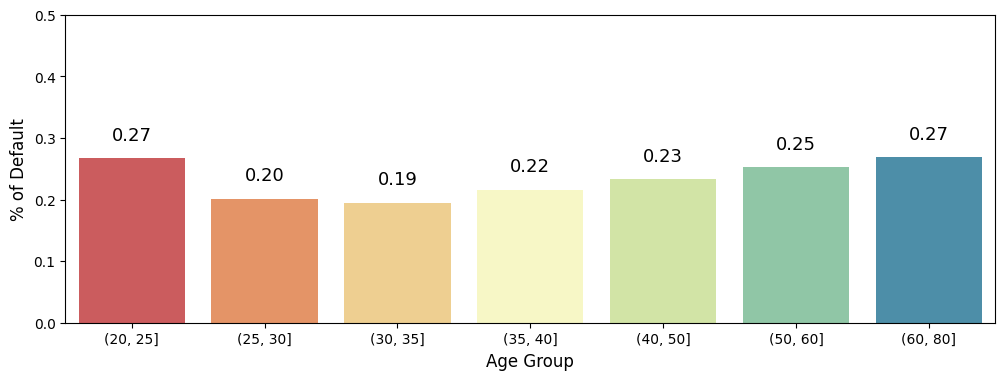

In [31]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "AgeBin", y = "Default", data = df, palette="Spectral", ci = None, order = AgeBin_order)

plt.xlabel("Age Group", fontsize= 12)
plt.ylabel("% of Default", fontsize= 12)
plt.ylim(0,0.5)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.25, p.get_height()+0.03),fontsize=13)

plt.show()

In line with expectations, the risk of default is lowest for people between 30 and 35 years old, and it is largest for people between 20- 25 and 60 - 80 years old.

## <a id="32">Given Credit and Repayment Status</a> 

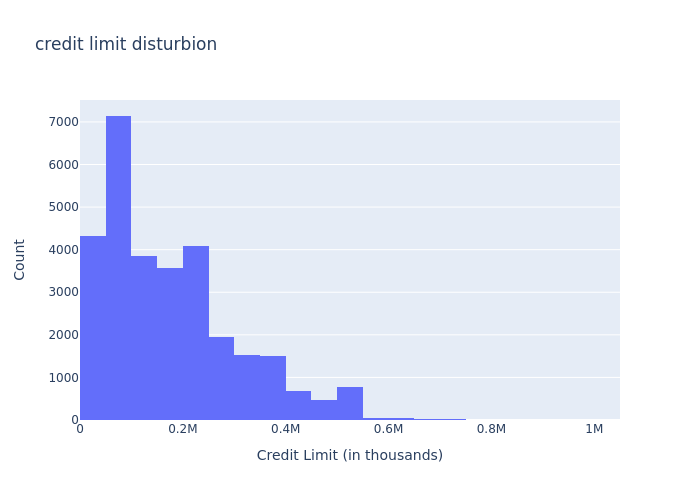

In [32]:
plot_title = 'credit limit disturbion'
plot_path = os.path.join(PLOT_DIR , f"{plot_title.replace(' ', '_')}.png")

fig = go.Figure()

fig.add_histogram(x=df['LIMIT_BAL'], nbinsx=20)

fig.update_layout( title=plot_title, xaxis_title='Credit Limit (in thousands)', yaxis_title='Count')

fig.write_image(plot_path)

Image(plot_path)

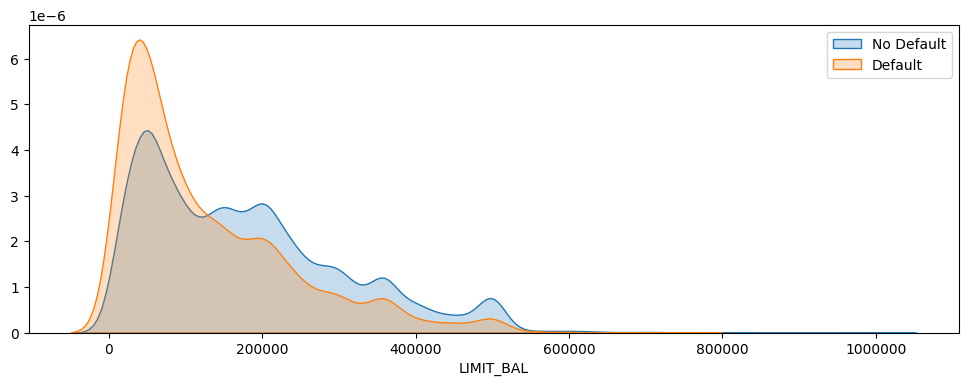

In [33]:
plt.figure(figsize=(12,4))

sns.kdeplot(df.loc[(df['Default'] == 0), 'LIMIT_BAL'], label = 'No Default', shade = True)
sns.kdeplot(df.loc[(df['Default'] == 1), 'LIMIT_BAL'], label = 'Default', shade = True)
plt.ticklabel_format(style='plain', axis='x') #repressing scientific notation on x
plt.ylabel('')
plt.legend()
plt.show()

Most customers have 200k or less of credit limit. And it seems that we will find a higher concentration of customers in default on that range. We will split it into bins to get a clear look.

In [34]:
df['LimitBin'] = pd.cut(df['LIMIT_BAL'],[5000, 50000, 100000, 150000, 200000, 300000, 400000, 500000, 1100000])
print(df['LimitBin'].value_counts())

(5000, 50000]        7676
(200000, 300000]     5059
(50000, 100000]      4822
(150000, 200000]     3978
(100000, 150000]     3902
(300000, 400000]     2759
(400000, 500000]     1598
(500000, 1100000]     206
Name: LimitBin, dtype: int64


In [35]:
df['Default'].groupby(df['LimitBin']).value_counts(normalize = True)

LimitBin           Default
(5000, 50000]      0          0.682126
                   1          0.317874
(50000, 100000]    0          0.742016
                   1          0.257984
(100000, 150000]   0          0.788570
                   1          0.211430
(150000, 200000]   0          0.821518
                   1          0.178482
(200000, 300000]   0          0.839494
                   1          0.160506
(300000, 400000]   0          0.859369
                   1          0.140631
(400000, 500000]   0          0.878598
                   1          0.121402
(500000, 1100000]  0          0.888350
                   1          0.111650
Name: Default, dtype: float64

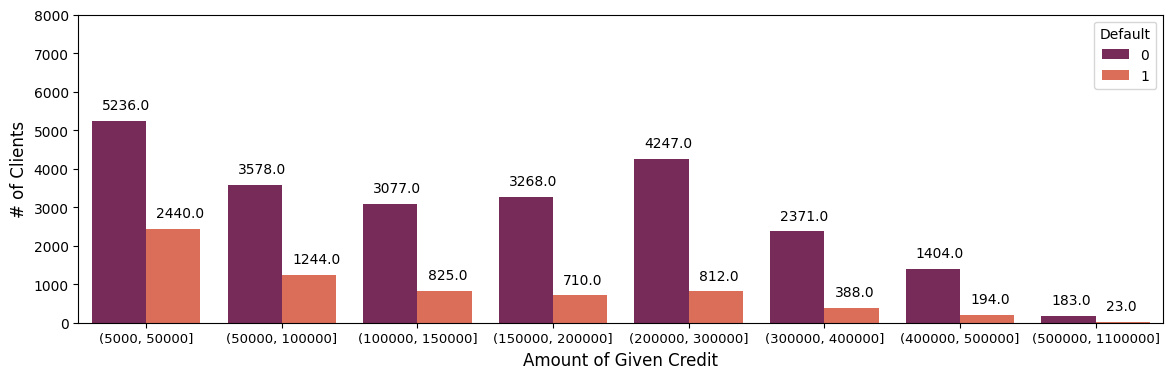

In [36]:
plt.figure(figsize=(14,4))

df['LimitBin'] = df['LimitBin'].astype('str')
LimitBin_order = ['(5000, 50000]', '(50000, 100000]', '(100000, 150000]', '(150000, 200000]',
                '(200000, 300000]', '(300000, 400000]', '(400000, 500000]', '(500000, 1100000]']

ax = sns.countplot(data = df, x = 'LimitBin', hue="Default", palette = 'rocket', order = LimitBin_order)

plt.xlabel("Amount of Given Credit", fontsize= 12)
plt.ylabel("# of Clients", fontsize= 12)
plt.ylim(0,8000)
ax.tick_params(axis="x", labelsize= 9.5)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.075, p.get_height()+300))

plt.show()


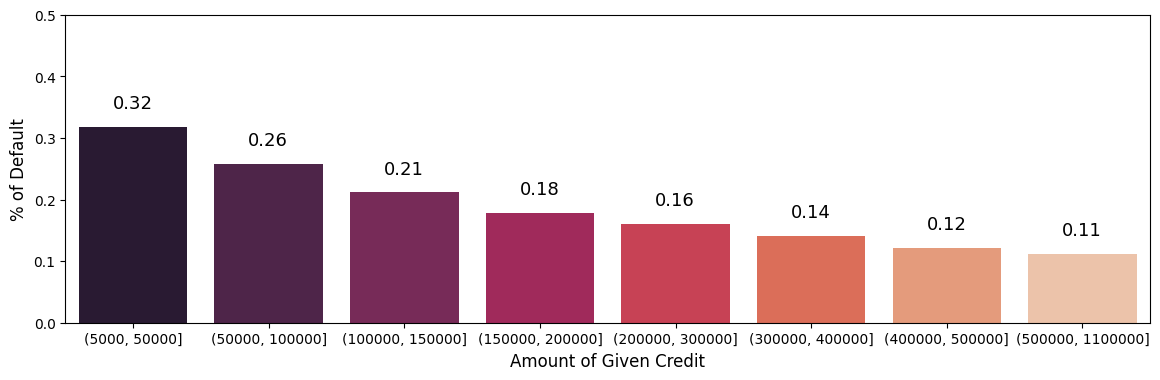

In [37]:
plt.figure(figsize=(14,4))

ax = sns.barplot(x = "LimitBin", y = "Default", data = df, palette = 'rocket', ci = None, order = LimitBin_order)

plt.xlabel("Amount of Given Credit", fontsize= 12)
plt.ylabel("% of Default", fontsize= 12)
plt.ylim(0,0.5)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.25, p.get_height()+0.03),fontsize=13)

plt.show()

In [38]:
df.groupby('SEX')['LIMIT_BAL'].mean()

SEX
1    163519.825034
2    170086.462014
Name: LIMIT_BAL, dtype: float64

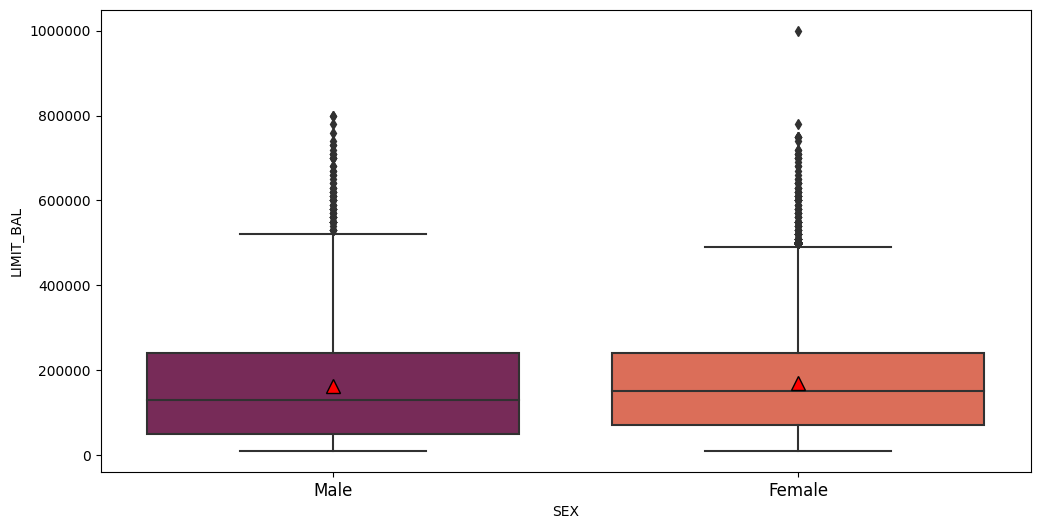

In [39]:
plt.figure(figsize=(12,6))

sns.boxplot(x = "SEX", y = "LIMIT_BAL",data = df, palette = 'rocket', showmeans=True, 
            meanprops={"markerfacecolor":"red",  "markeredgecolor":"black", "markersize":"10"})

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation    
plt.xticks([0,1],['Male', 'Female'], fontsize = 12)

plt.show()

In [40]:
df.groupby('EDUCATION')['LIMIT_BAL'].mean()

EDUCATION
1    212956.069910
2    147062.437634
3    126550.270490
4    220894.308943
5    167205.797101
Name: LIMIT_BAL, dtype: float64

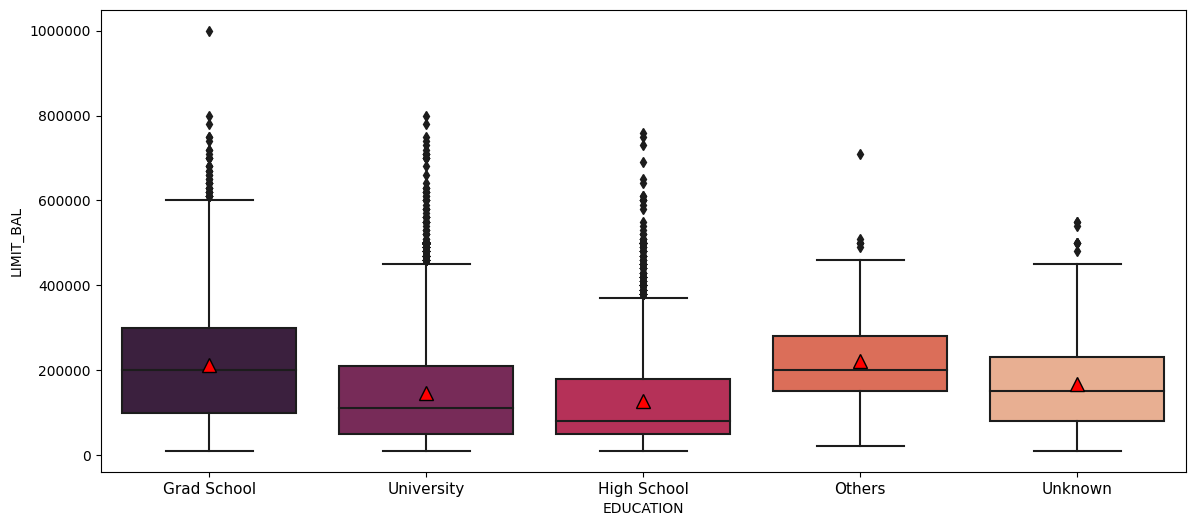

In [41]:
plt.figure(figsize=(14,6))

sns.boxplot(x = "EDUCATION", y = "LIMIT_BAL", data = df, palette = 'rocket', showmeans=True, 
            meanprops={"markerfacecolor":"red",  "markeredgecolor":"black", "markersize":"10"})

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation   
plt.xticks([0,1,2,3,4],['Grad School','University','High School','Others','Unknown'], fontsize = 11)

plt.show()

In [42]:
df.groupby('MARRIAGE')['LIMIT_BAL'].mean()

MARRIAGE
0    132962.962963
1    182200.893184
2    156413.660737
3     98080.495356
Name: LIMIT_BAL, dtype: float64

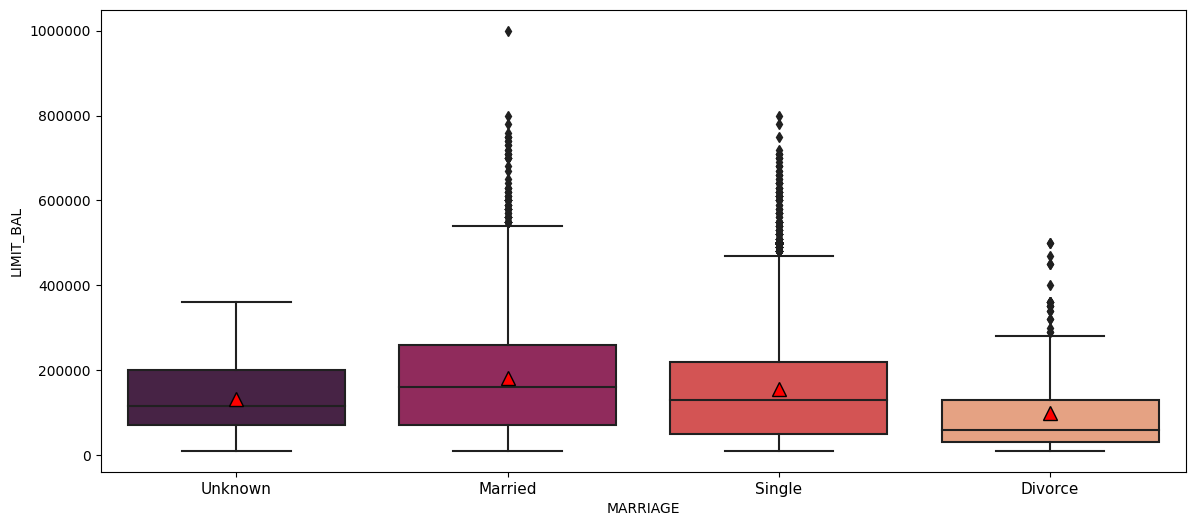

In [43]:
plt.figure(figsize=(14,6))

sns.boxplot(x = "MARRIAGE", y = "LIMIT_BAL", data = df, palette = 'rocket', showmeans=True, 
            meanprops={"markerfacecolor":"red",  "markeredgecolor":"black", "markersize":"10"})

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation    
plt.xticks([0,1,2,3],['Unknown', 'Married', 'Single', 'Divorce'], fontsize = 11)

plt.show()

In [44]:
df.groupby('AgeBin')['LIMIT_BAL'].mean()

AgeBin
(20, 25]     73763.885301
(25, 30]    164320.918510
(30, 35]    197688.060732
(35, 40]    196780.557250
(40, 50]    179680.213156
(50, 60]    159349.023535
(60, 80]    201617.647059
Name: LIMIT_BAL, dtype: float64

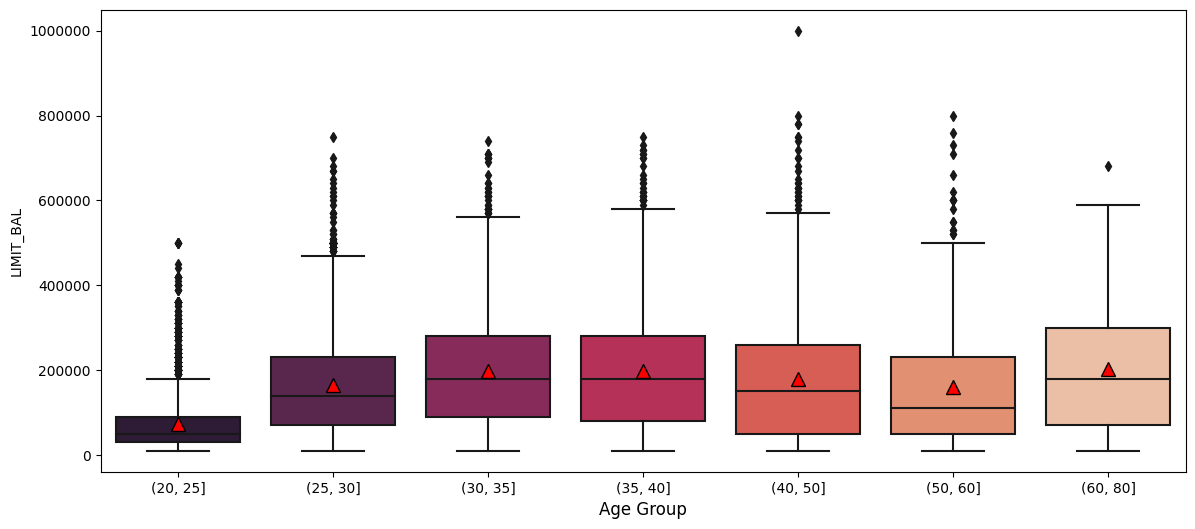

In [45]:
plt.figure(figsize=(14,6))

sns.boxplot(x = "AgeBin", y = "LIMIT_BAL",data = df, palette = 'rocket', order = AgeBin_order, showmeans=True, 
            meanprops={"markerfacecolor":"red",  "markeredgecolor":"black", "markersize":"10"})

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation    
plt.xlabel("Age Group", fontsize= 12)

plt.show()

Generally, the available credit limit appears to be in line with each category's ability to make timely payments. The exceptions are the unknown category, which have lower default rates but do not typically earn the greatest credit amounts, and the 60+ age group, which despite having one of the highest default rates still typically obtains the highest credit amounts by age group.

To check if there is a different association between the credit limit and the combination of the two demographic factors, we might do an analysis. I'll only plot the'sex' feature together with the other demographic data in this notebook.

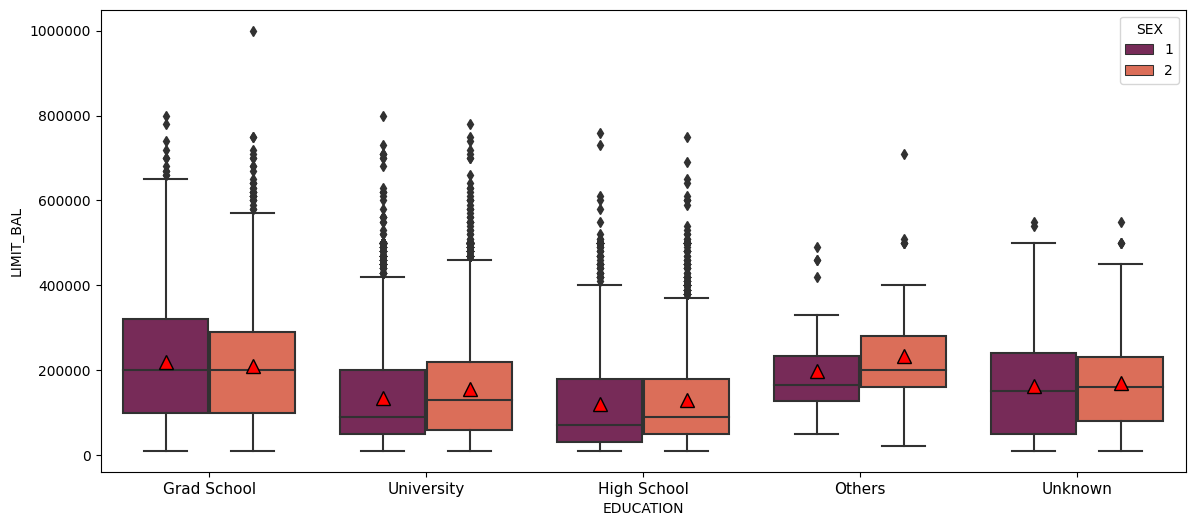

In [46]:
plt.figure(figsize=(14,6))

sns.boxplot(x = "EDUCATION", y = "LIMIT_BAL", hue = 'SEX', data = df, palette = 'rocket', showmeans=True, 
            meanprops={"markerfacecolor":"red",  "markeredgecolor":"black", "markersize":"10"})

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation   
plt.xticks([0,1,2,3,4],['Grad School','University','High School','Others','Unknown'], fontsize = 11)

plt.show()

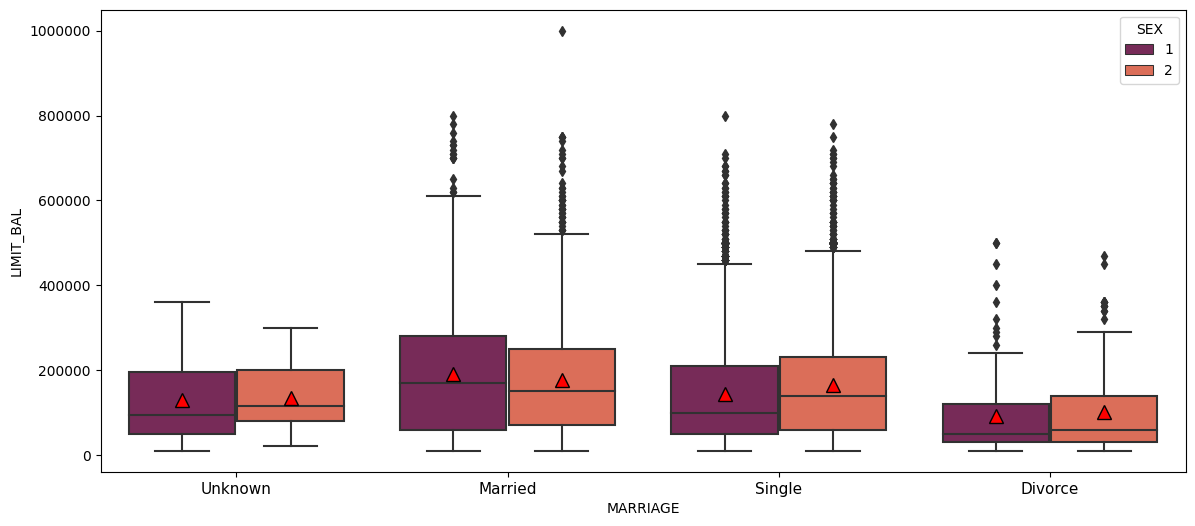

In [47]:
plt.figure(figsize=(14,6))

sns.boxplot(x = "MARRIAGE", y = "LIMIT_BAL", hue = 'SEX', data = df, palette = 'rocket', showmeans=True, 
            meanprops={"markerfacecolor":"red",  "markeredgecolor":"black", "markersize":"10"})

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation    
plt.xticks([0,1,2,3],['Unknown', 'Married', 'Single', 'Divorce'], fontsize = 11)

plt.show()

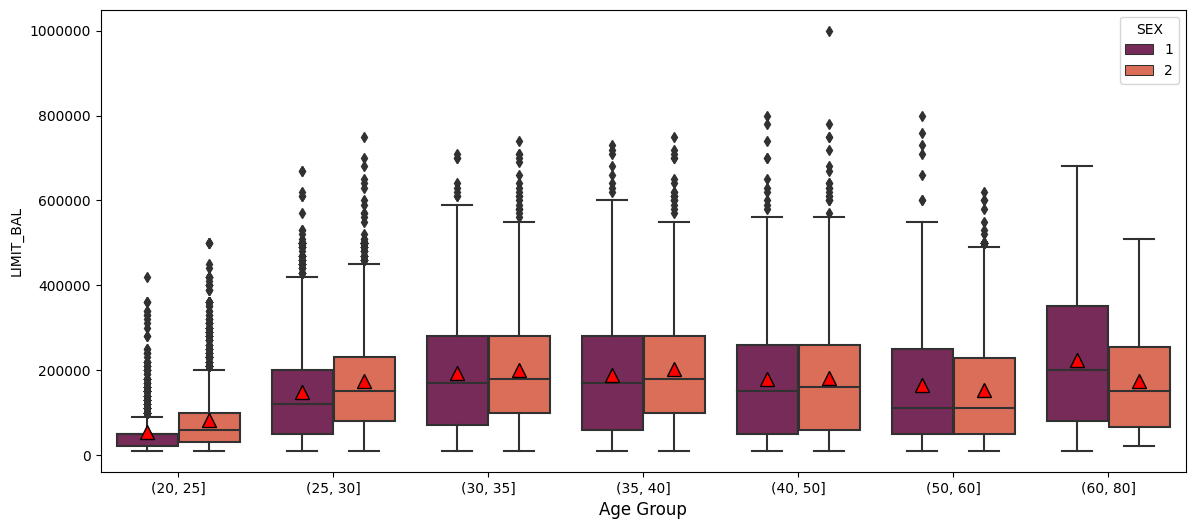

In [48]:
plt.figure(figsize=(14,6))

sns.boxplot(x = "AgeBin", y = "LIMIT_BAL", hue = 'SEX', data = df, palette = 'rocket', order = AgeBin_order, showmeans=True, 
            meanprops={"markerfacecolor":"red",  "markeredgecolor":"black", "markersize":"10"})

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation    
plt.xlabel("Age Group", fontsize= 12)

plt.show()

We saw earlier that the average given credit for women was slightly higher than for men. That still holds up for several combinations of categories, except among customers that: 
- Have a grad school diploma; 
- Are married;
- Are 50+ years old.

## Repayment Status (PAY_X)

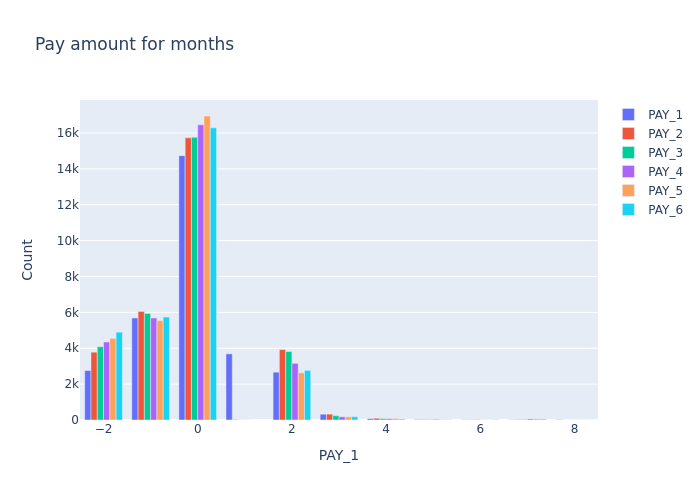

In [49]:
plot_title = 'Pay amount for months'
plot_path = os.path.join(PLOT_DIR, f'{plot_title.replace(" " , "_")}.png')
pay_x_fts = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
fig = go.Figure()
for pay_x_fts in pay_x_fts:
    fig.add_bar(x=df[pay_x_fts].value_counts().index, y=df[pay_x_fts].value_counts().values, name=pay_x_fts)
    # show legend and show values on the top of the bars

fig.update_layout(title_text=plot_title, xaxis_title_text='PAY_1', yaxis_title_text='Count',)

fig.write_image(plot_path)

Image(plot_path)

Most customers are duly paying their credit card bills. And it's pretty clear that their likelihood of default are much lower than the rest.

Since there are only a few customers with 4+ months of delay in all PAY_X features, we could make a new analysis with them all together just to have the average default of a more significant group.

In [50]:
df['PAY_1_new'] = df['PAY_1'].copy()
df['PAY_2_new'] = df['PAY_2'].copy()
df['PAY_3_new'] = df['PAY_3'].copy()
df['PAY_4_new'] = df['PAY_4'].copy()
df['PAY_5_new'] = df['PAY_5'].copy()
df['PAY_6_new'] = df['PAY_6'].copy()

In [51]:
pay_x_new = ['PAY_1_new', 'PAY_2_new', 'PAY_3_new', 'PAY_4_new', 'PAY_5_new', 'PAY_6_new']

for col in pay_x_new:  
    df.loc[:,col] = df.loc[:,col].replace(5,4)
    df.loc[:,col] = df.loc[:,col].replace(6,4)
    df.loc[:,col] = df.loc[:,col].replace(7,4)
    df.loc[:,col] = df.loc[:,col].replace(8,4)

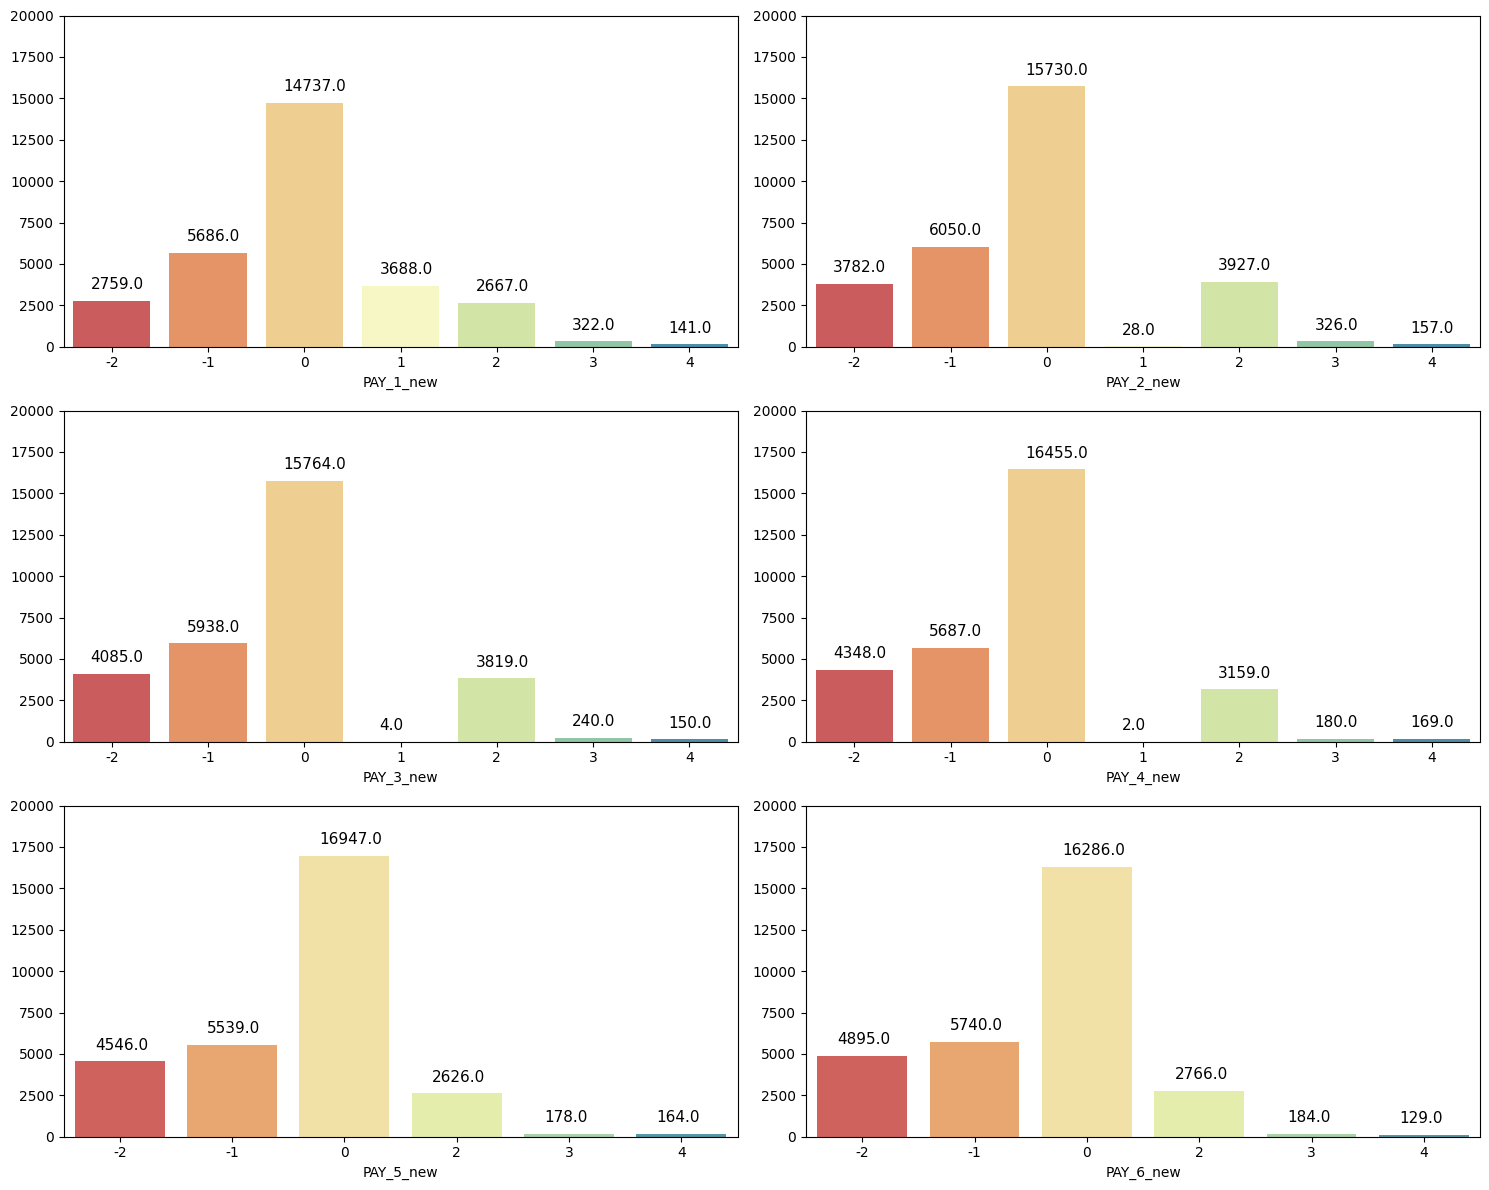

In [52]:
plt.figure(figsize=(15,12))

for i,col in enumerate(pay_x_new):    
    plt.subplot(3,2,i + 1)
    ax = sns.countplot(data = df, x = col, palette = "Spectral")
    plt.ylim(0,20000)
    plt.ylabel('')
    plt.tight_layout()
    
    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.180, p.get_height()+700), fontsize = 11)

plt.show()

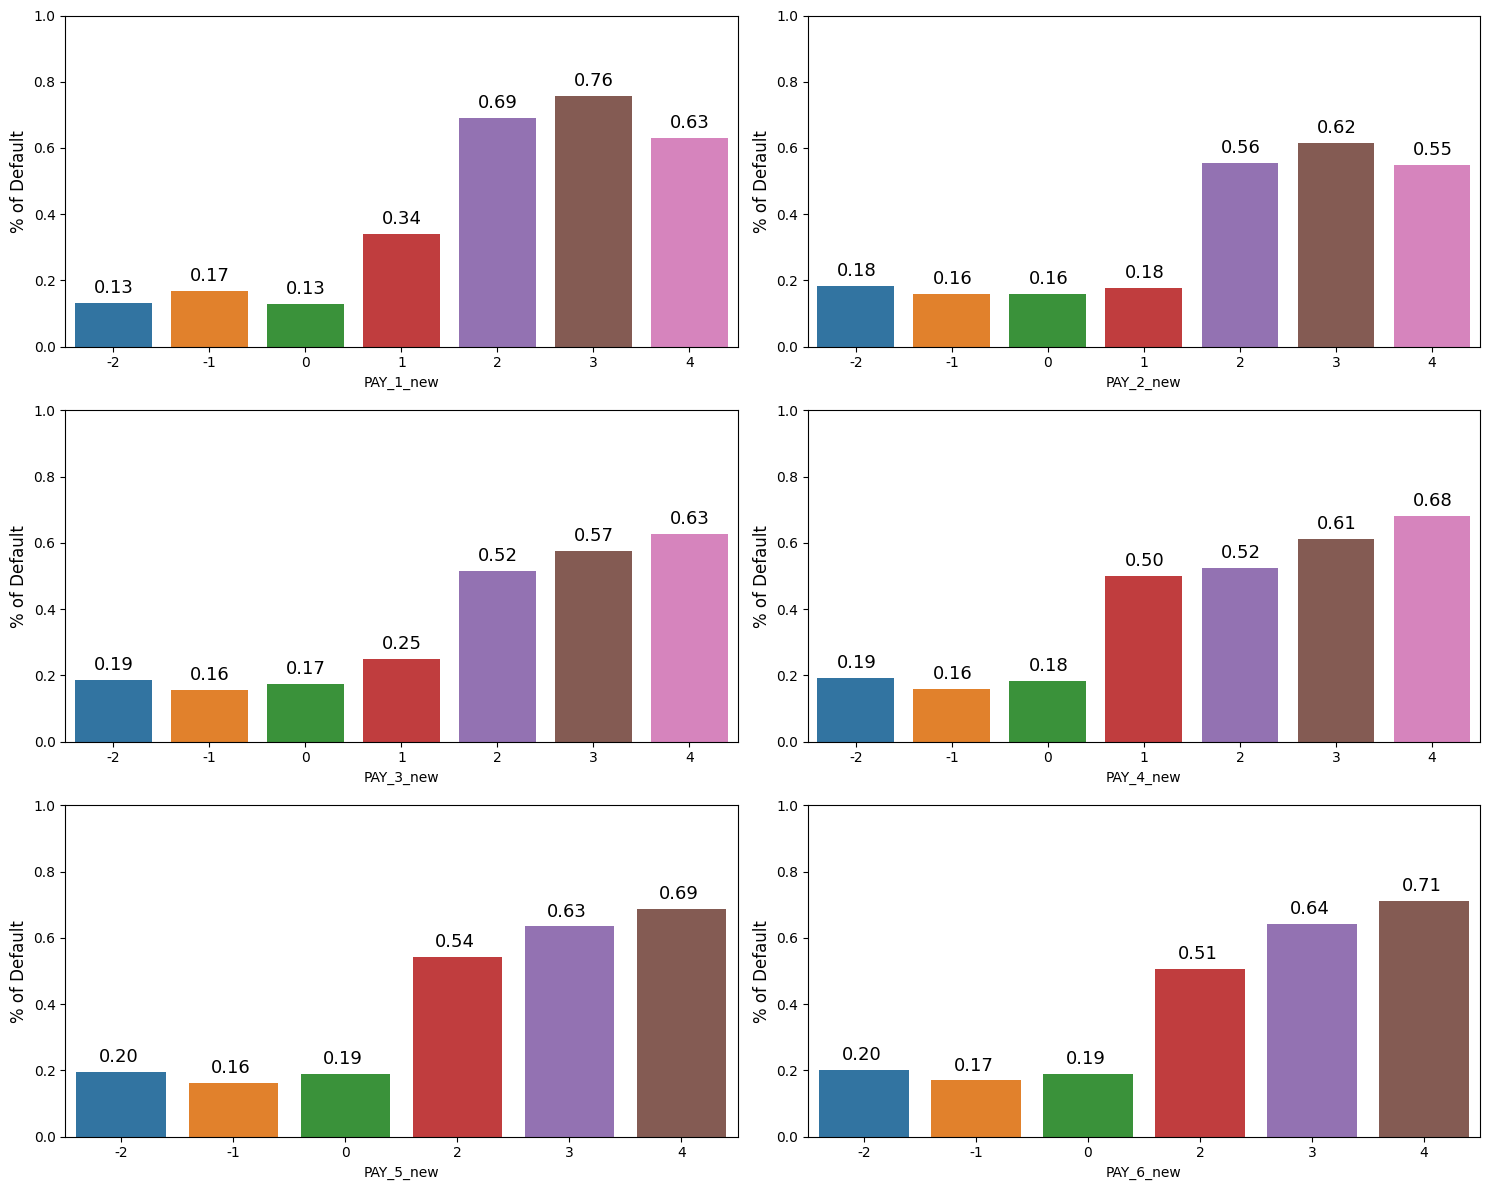

In [53]:
plt.figure(figsize=(15,12))

for i,col in enumerate(pay_x_new):    
    plt.subplot(3,2,i + 1)
    ax = sns.barplot(x = col, y = "Default", data = df, ci = None)
    plt.ylabel("% of Default", fontsize= 12)
    plt.ylim(0,1.0)
    plt.tight_layout()
    
    for p in ax.patches:
        ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.20, p.get_height()+0.03),fontsize=13)

plt.show()

## Amount of Bill Statement (BILL_AMTX)

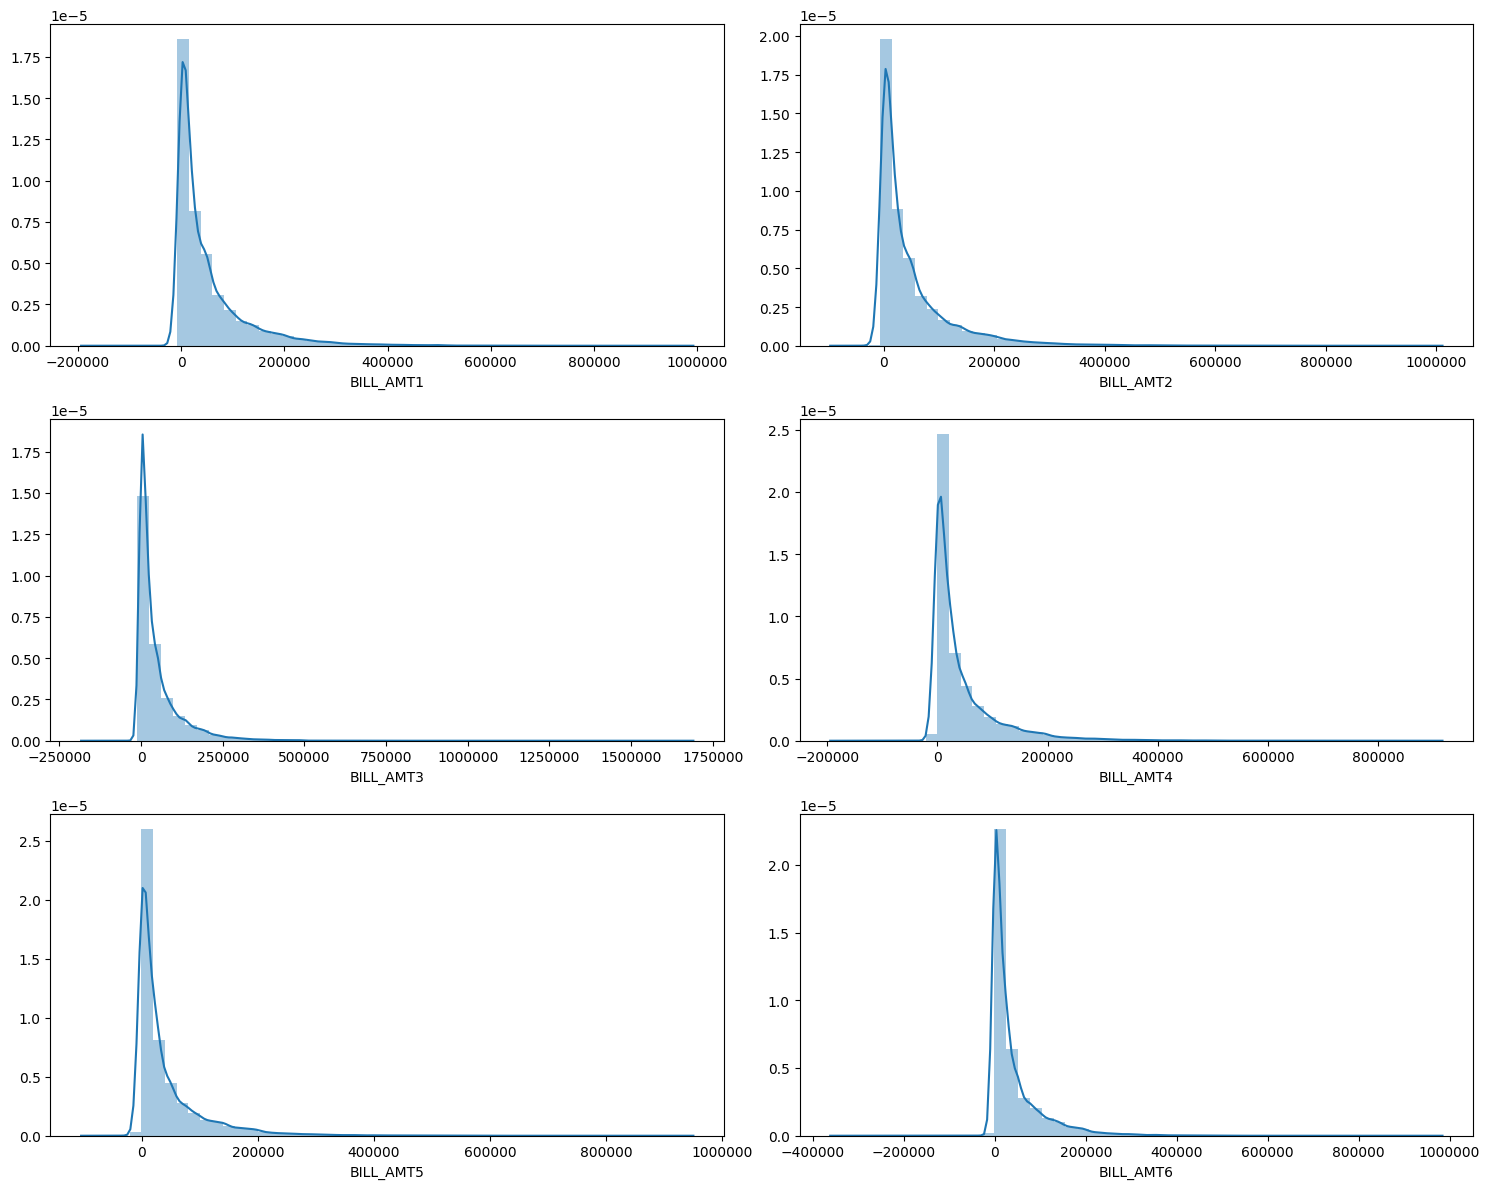

In [54]:
bill_amtx_fts = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
plt.figure(figsize=(15,12))

for i,col in enumerate(bill_amtx_fts):    
    plt.subplot(3,2,i + 1)
    sns.distplot(df.loc[:,col])
    plt.ticklabel_format(style='plain', axis='x') #repressing scientific notation    
    plt.ylabel('')
    plt.tight_layout()

plt.show()

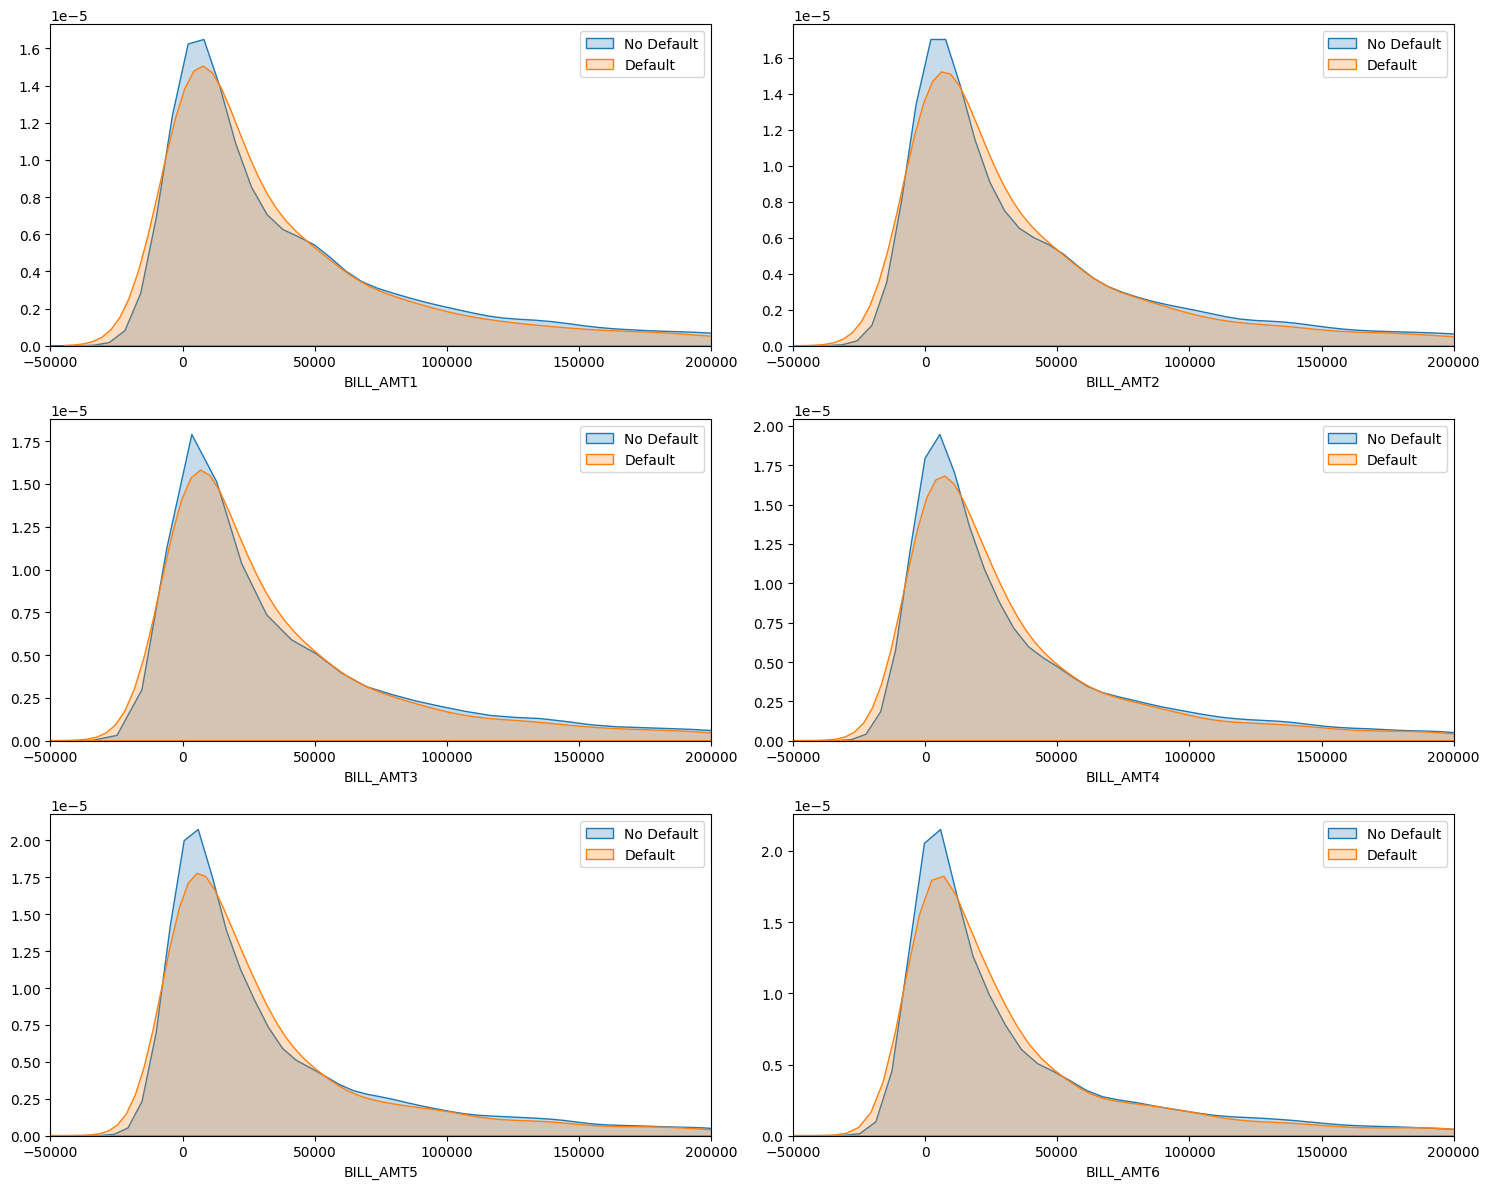

In [55]:
plt.figure(figsize=(15,12))

for i,col in enumerate(bill_amtx_fts):    
    plt.subplot(3,2,i + 1)    
    sns.kdeplot(df.loc[(df['Default'] == 0), col], label = 'No Default', shade = True)
    sns.kdeplot(df.loc[(df['Default'] == 1), col], label = 'Default', shade = True)
    plt.xlim(-50000,200000)
    plt.ylabel('')
    plt.legend()
    plt.tight_layout()

plt.show()

In [56]:
df['BILL_AMT1_bin'] = df['BILL_AMT1'].copy()
df['BILL_AMT2_bin'] = df['BILL_AMT2'].copy()
df['BILL_AMT3_bin'] = df['BILL_AMT3'].copy()
df['BILL_AMT4_bin'] = df['BILL_AMT4'].copy()
df['BILL_AMT5_bin'] = df['BILL_AMT5'].copy()
df['BILL_AMT6_bin'] = df['BILL_AMT6'].copy()

In [57]:
bill_amtx_bins = ['BILL_AMT1_bin', 'BILL_AMT2_bin', 'BILL_AMT3_bin', 'BILL_AMT4_bin', 'BILL_AMT5_bin', 'BILL_AMT6_bin']

for i, col in enumerate (bill_amtx_bins):
    df[col] = pd.cut(df[bill_amtx_fts[i]],[-350000,-1,0,25000, 75000, 200000, 2000000])
    print(df[col].value_counts())

(0, 25000]           12965
(25000, 75000]        7656
(75000, 200000]       5258
(-1, 0]               2008
(200000, 2000000]     1523
(-350000, -1]          590
Name: BILL_AMT1_bin, dtype: int64
(0, 25000]           12647
(25000, 75000]        7692
(75000, 200000]       5094
(-1, 0]               2506
(200000, 2000000]     1392
(-350000, -1]          669
Name: BILL_AMT2_bin, dtype: int64
(0, 25000]           12696
(25000, 75000]        7635
(75000, 200000]       4888
(-1, 0]               2870
(200000, 2000000]     1256
(-350000, -1]          655
Name: BILL_AMT3_bin, dtype: int64
(0, 25000]           13081
(25000, 75000]        7401
(75000, 200000]       4623
(-1, 0]               3195
(200000, 2000000]     1025
(-350000, -1]          675
Name: BILL_AMT4_bin, dtype: int64
(0, 25000]           13401
(25000, 75000]        7163
(75000, 200000]       4399
(-1, 0]               3506
(200000, 2000000]      876
(-350000, -1]          655
Name: BILL_AMT5_bin, dtype: int64
(0, 25000]          

In [58]:
for col in bill_amtx_bins:
    print(df['Default'].groupby(df[col]).value_counts(normalize = True))

BILL_AMT1_bin      Default
(-350000, -1]      0          0.815254
                   1          0.184746
(-1, 0]            0          0.734064
                   1          0.265936
(0, 25000]         0          0.774470
                   1          0.225530
(25000, 75000]     0          0.775209
                   1          0.224791
(75000, 200000]    0          0.802396
                   1          0.197604
(200000, 2000000]  0          0.797111
                   1          0.202889
Name: Default, dtype: float64
BILL_AMT2_bin      Default
(-350000, -1]      0          0.810164
                   1          0.189836
(-1, 0]            0          0.753791
                   1          0.246209
(0, 25000]         0          0.775836
                   1          0.224164
(25000, 75000]     0          0.773531
                   1          0.226469
(75000, 200000]    0          0.799176
                   1          0.200824
(200000, 2000000]  0          0.790230
                   

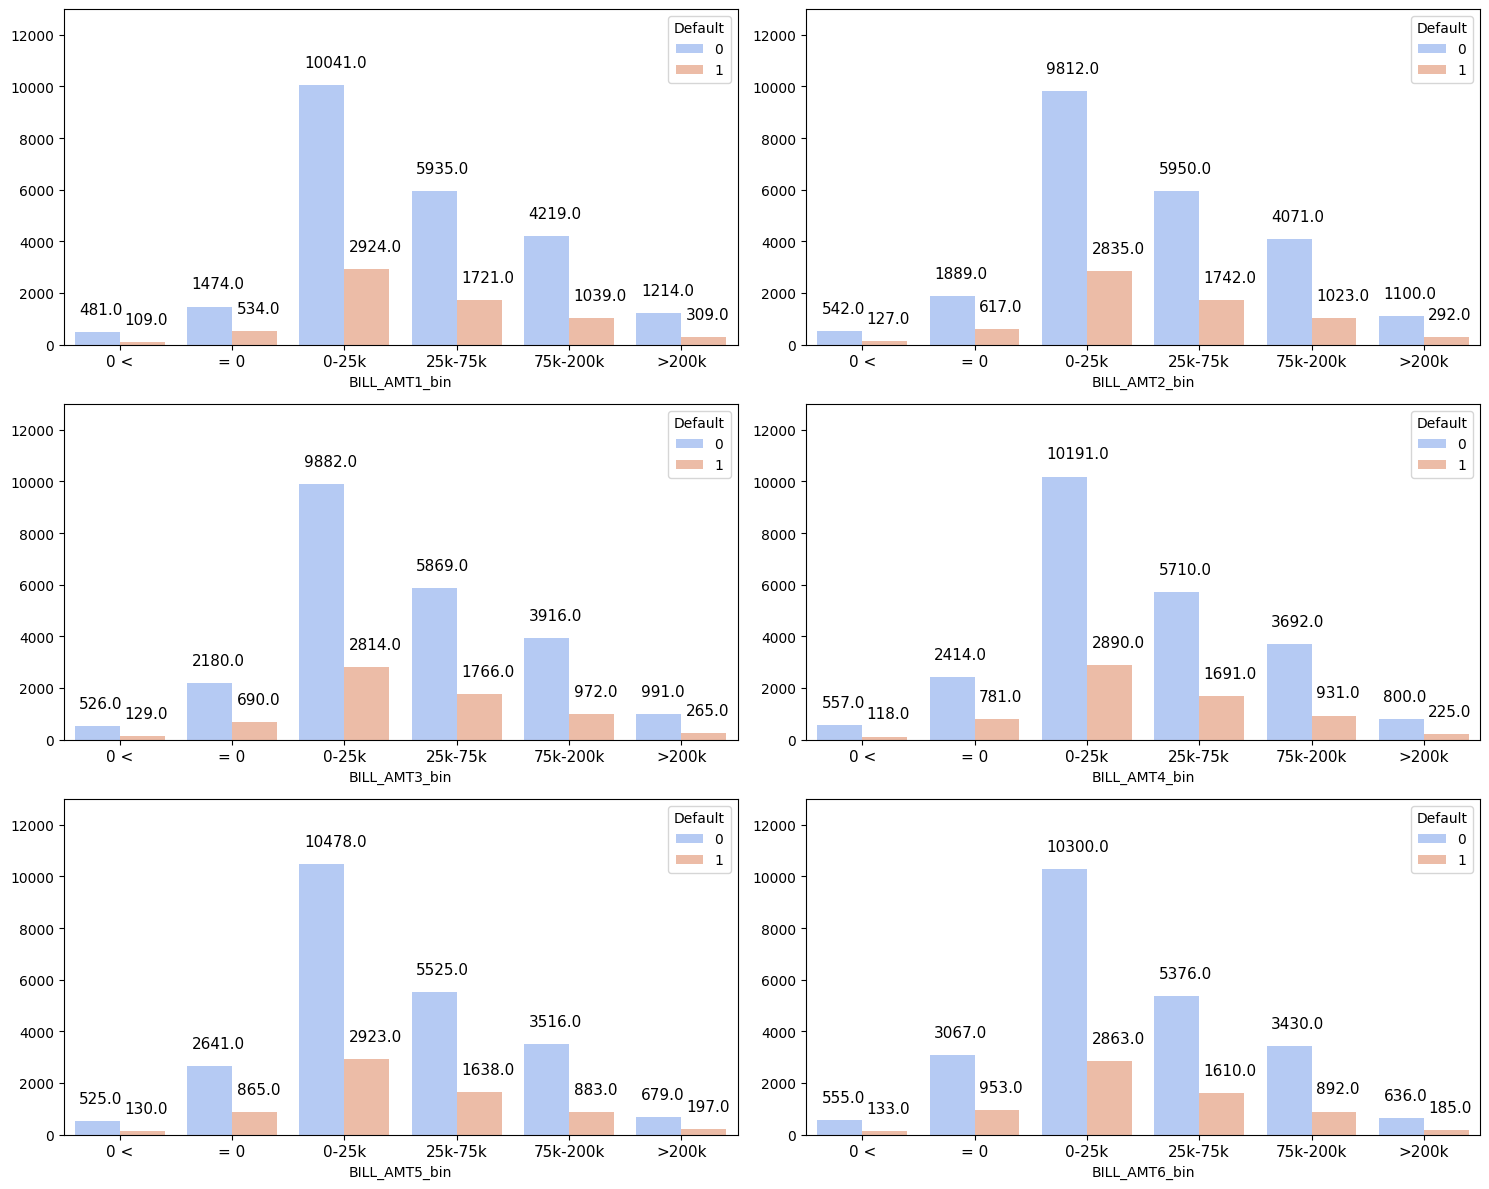

In [59]:
plt.figure(figsize=(15,12))

for i,col in enumerate(bill_amtx_bins):    
    plt.subplot(3,2,i + 1)
    ax = sns.countplot(data = df, x = col, hue="Default", palette = 'coolwarm')
    plt.ylim(0,13000)
    plt.ylabel('')
    plt.xticks([0,1,2,3,4,5],['0 <', '= 0', '0-25k', '25k-75k', '75k-200k', '>200k'], fontsize = 11)
    plt.tight_layout()

    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.04, p.get_height()+700), fontsize = 11)    
        
plt.show()

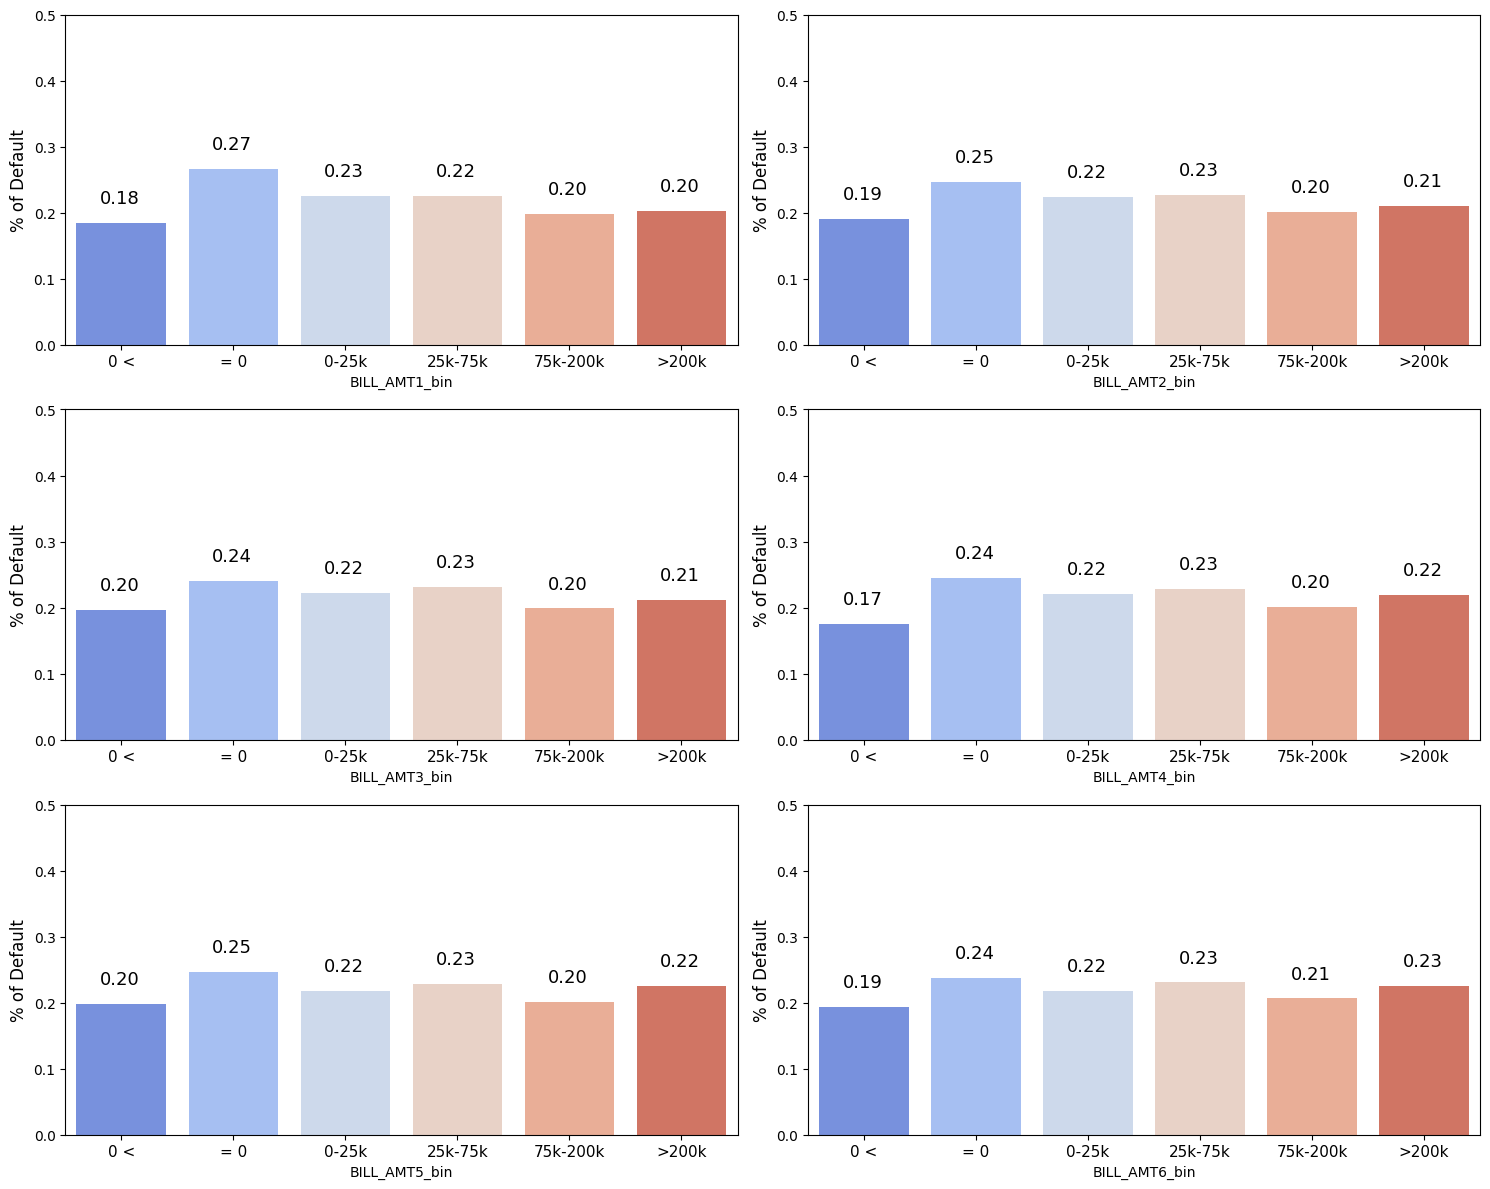

In [60]:
plt.figure(figsize=(15,12))

for i,col in enumerate(bill_amtx_bins):    
    plt.subplot(3,2,i + 1)
    ax = sns.barplot(x = col, y = "Default", data = df, palette = 'coolwarm', ci = None)
    plt.ylabel("% of Default", fontsize= 12)
    plt.ylim(0,0.5)
    plt.xticks([0,1,2,3,4,5],['0 <', '= 0', '0-25k', '25k-75k', '75k-200k', '>200k'], fontsize = 11)    
    plt.tight_layout()
    
    for p in ax.patches:
        ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.21, p.get_height()+0.03),fontsize=13)

plt.show()

## Amount of Previous Payment (PAY_AMTX)

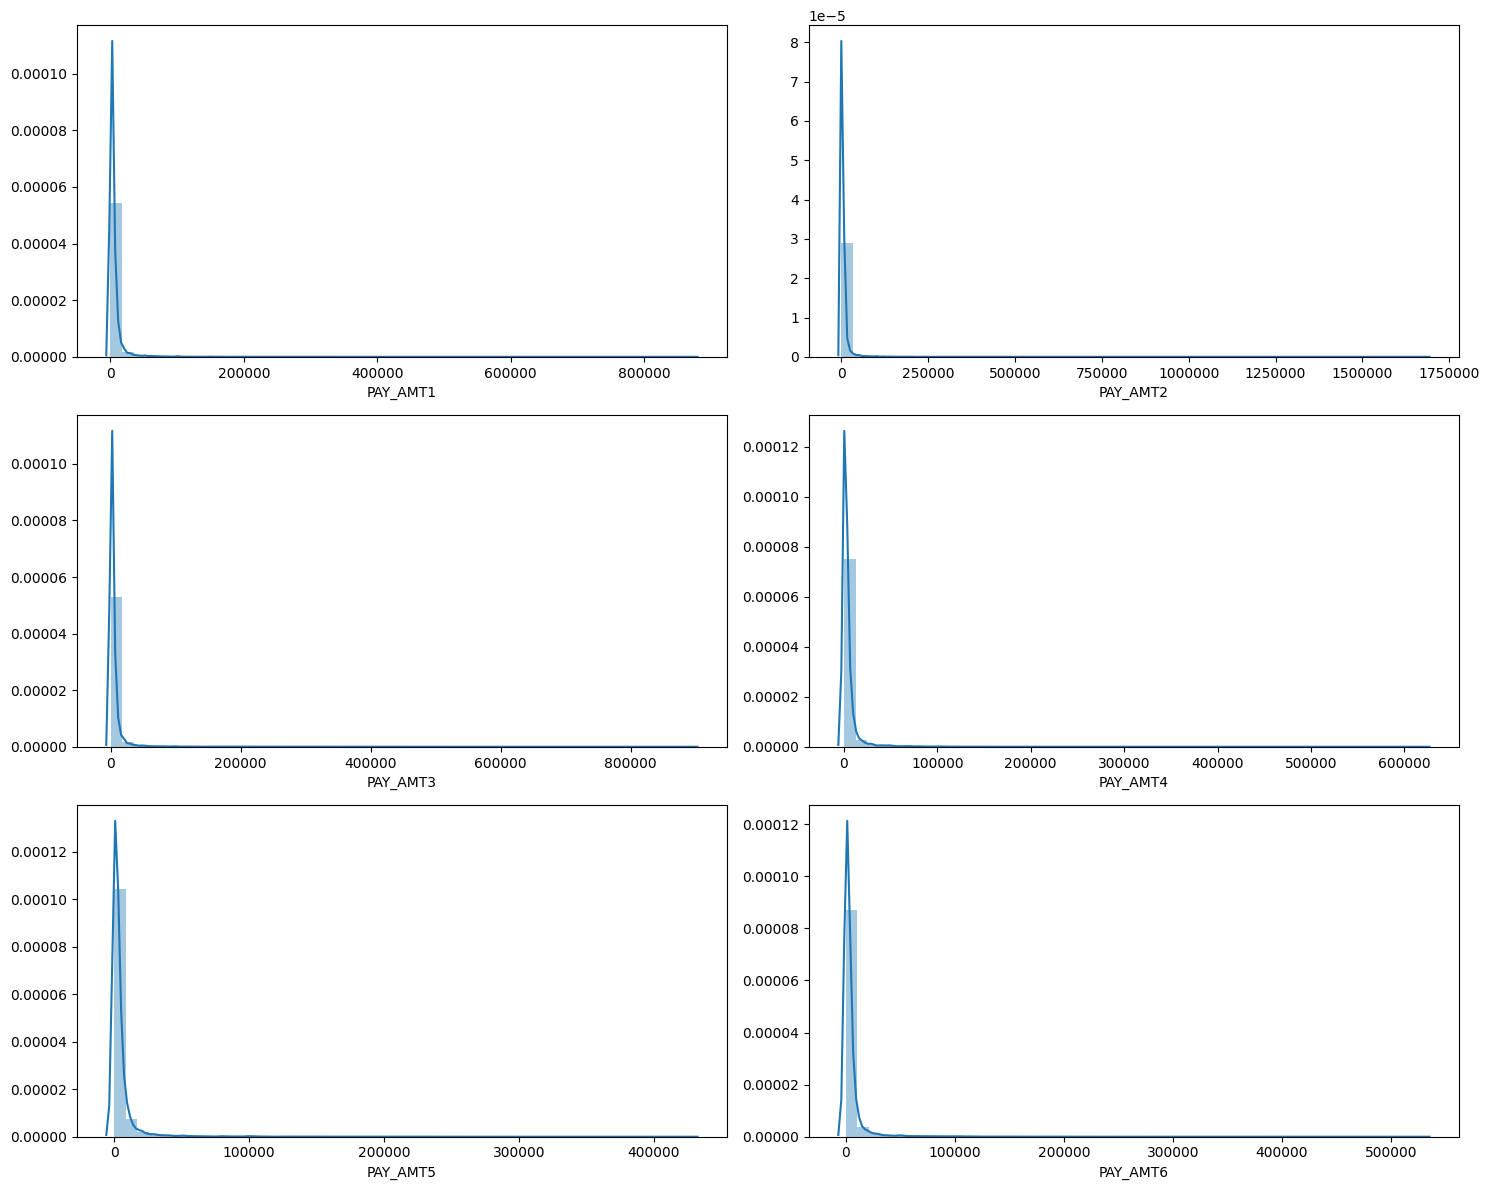

In [61]:
pay_amtx_fts = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
plt.figure(figsize=(15,12))

for i,col in enumerate(pay_amtx_fts):    
    plt.subplot(3,2,i + 1)
    sns.distplot(df.loc[:,col])
    plt.ticklabel_format(style='plain', axis='x') #repressing scientific notation
    plt.ylabel('')
    plt.tight_layout()

plt.show()

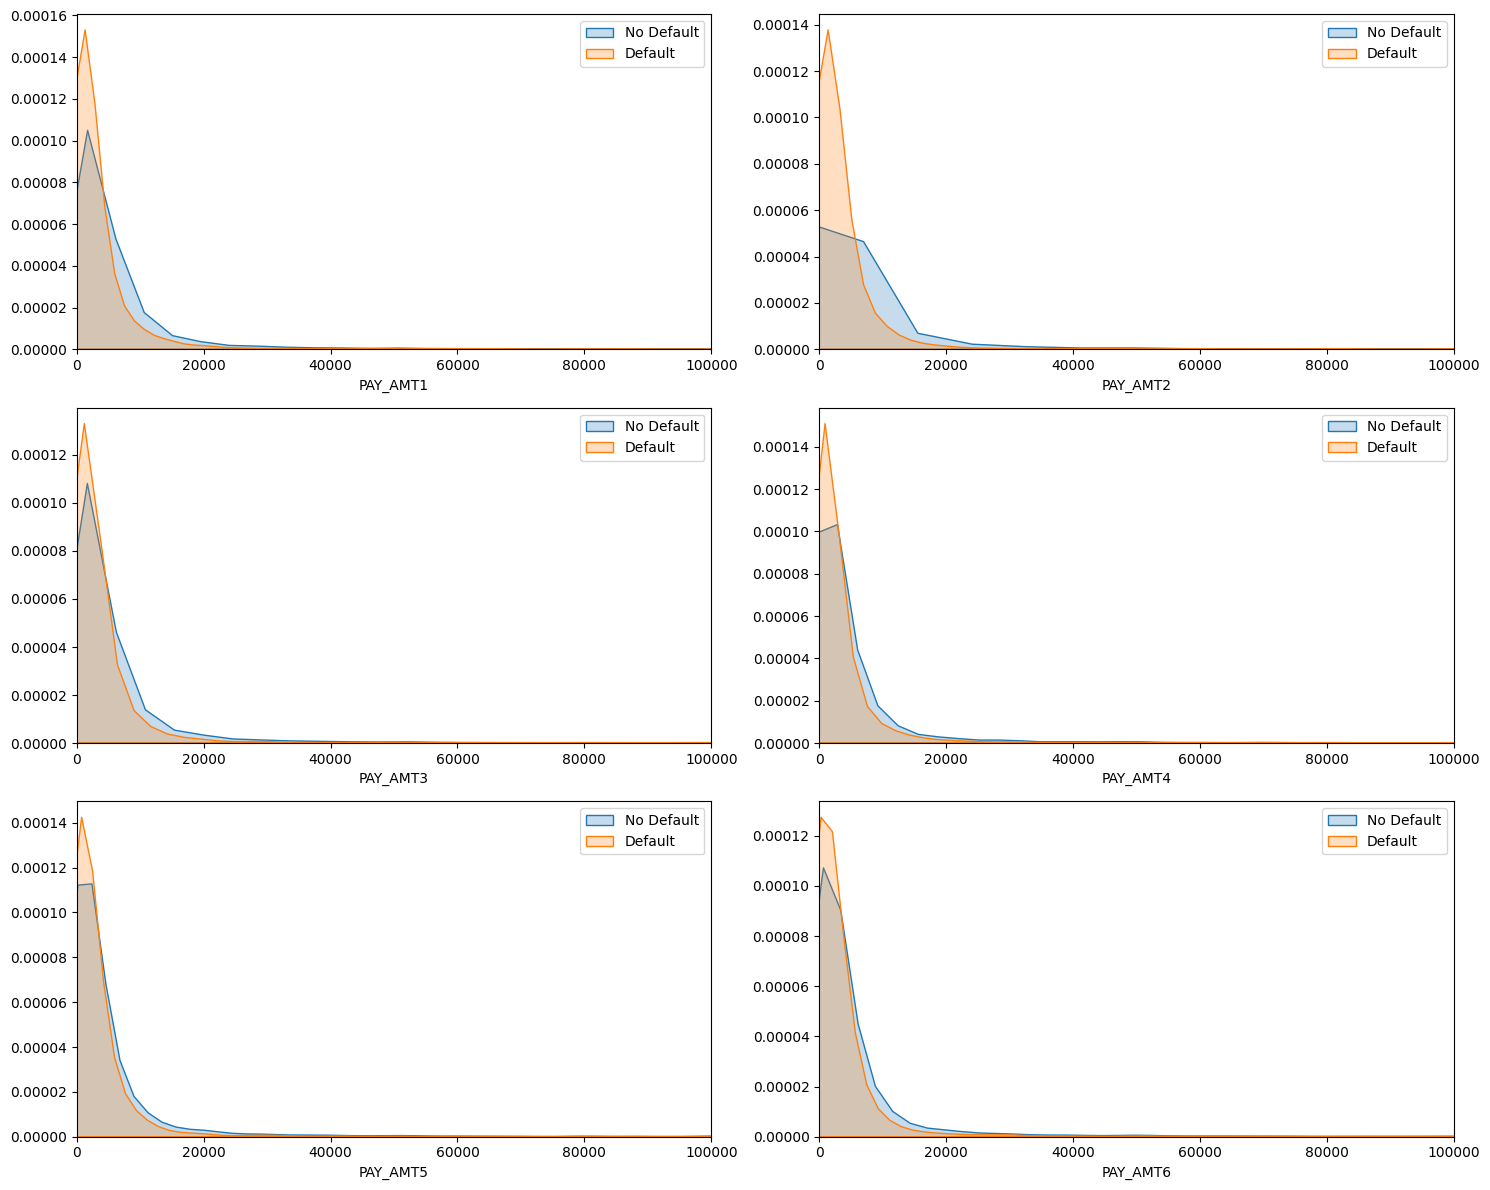

In [62]:
plt.figure(figsize=(15,12))

for i,col in enumerate(pay_amtx_fts):    
    plt.subplot(3,2,i + 1)    
    sns.kdeplot(df.loc[(df['Default'] == 0), col], label = 'No Default', shade = True)
    sns.kdeplot(df.loc[(df['Default'] == 1), col], label = 'Default', shade = True)
    plt.xlim(0,100000)
    plt.ylabel('')
    plt.legend()
    plt.tight_layout()

plt.show()

In [63]:
df['PAY_AMT1_bin'] = df['PAY_AMT1'].copy()
df['PAY_AMT2_bin'] = df['PAY_AMT2'].copy()
df['PAY_AMT3_bin'] = df['PAY_AMT3'].copy()
df['PAY_AMT4_bin'] = df['PAY_AMT4'].copy()
df['PAY_AMT5_bin'] = df['PAY_AMT5'].copy()
df['PAY_AMT6_bin'] = df['PAY_AMT6'].copy()

In [64]:
pay_amtx_bins = ['PAY_AMT1_bin', 'PAY_AMT2_bin', 'PAY_AMT3_bin', 'PAY_AMT4_bin', 'PAY_AMT5_bin', 'PAY_AMT6_bin']

for i, col in enumerate (pay_amtx_bins):
    df[col] = pd.cut(df[pay_amtx_fts[i]],[-1, 0, 25000, 50000, 100000, 2000000])
    print(df[col].value_counts())

(0, 25000]           23730
(-1, 0]               5249
(25000, 50000]         550
(50000, 100000]        322
(100000, 2000000]      149
Name: PAY_AMT1_bin, dtype: int64
(0, 25000]           23569
(-1, 0]               5396
(25000, 50000]         556
(50000, 100000]        283
(100000, 2000000]      196
Name: PAY_AMT2_bin, dtype: int64
(0, 25000]           23068
(-1, 0]               5968
(25000, 50000]         514
(50000, 100000]        273
(100000, 2000000]      177
Name: PAY_AMT3_bin, dtype: int64
(0, 25000]           22641
(-1, 0]               6408
(25000, 50000]         533
(50000, 100000]        271
(100000, 2000000]      147
Name: PAY_AMT4_bin, dtype: int64
(0, 25000]           22382
(-1, 0]               6703
(25000, 50000]         493
(50000, 100000]        268
(100000, 2000000]      154
Name: PAY_AMT5_bin, dtype: int64
(0, 25000]           21785
(-1, 0]               7173
(25000, 50000]         517
(50000, 100000]        300
(100000, 2000000]      225
Name: PAY_AMT6_bin, dtype

In [65]:
for col in pay_amtx_bins:
    print(df['Default'].groupby(df[col]).value_counts(normalize = True))

PAY_AMT1_bin       Default
(-1, 0]            0          0.640503
                   1          0.359497
(0, 25000]         0          0.803582
                   1          0.196418
(25000, 50000]     0          0.910909
                   1          0.089091
(50000, 100000]    0          0.919255
                   1          0.080745
(100000, 2000000]  0          0.912752
                   1          0.087248
Name: Default, dtype: float64
PAY_AMT2_bin       Default
(-1, 0]            0          0.666605
                   1          0.333395
(0, 25000]         0          0.797997
                   1          0.202003
(25000, 50000]     0          0.926259
                   1          0.073741
(50000, 100000]    0          0.936396
                   1          0.063604
(100000, 2000000]  0          0.913265
                   1          0.086735
Name: Default, dtype: float64
PAY_AMT3_bin       Default
(-1, 0]            0          0.676441
                   1          0.323559
(

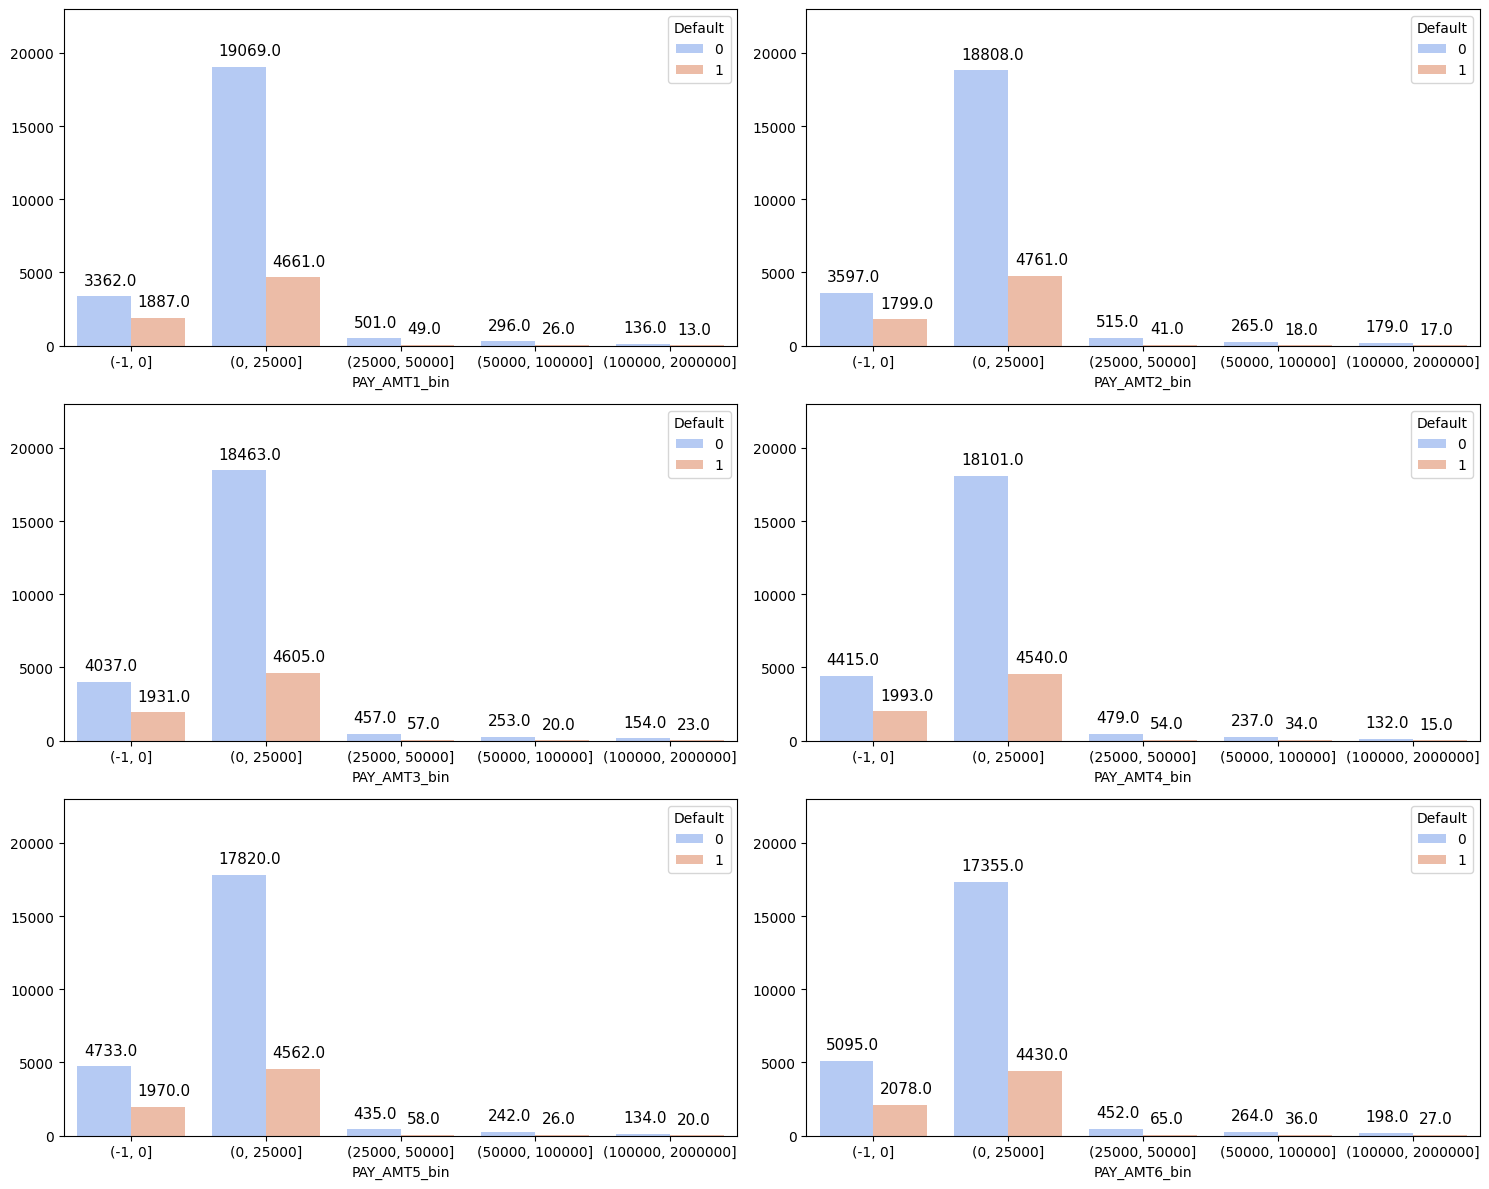

In [66]:
plt.figure(figsize=(15,12))

for i,col in enumerate(pay_amtx_bins):    
    plt.subplot(3,2,i + 1)
    ax = sns.countplot(data = df, x = col, hue="Default", palette = 'coolwarm')
    plt.ylim(0,23000)
    plt.ylabel('')
    plt.tight_layout()
    
    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.05, p.get_height()+800), fontsize=11)    

plt.show()

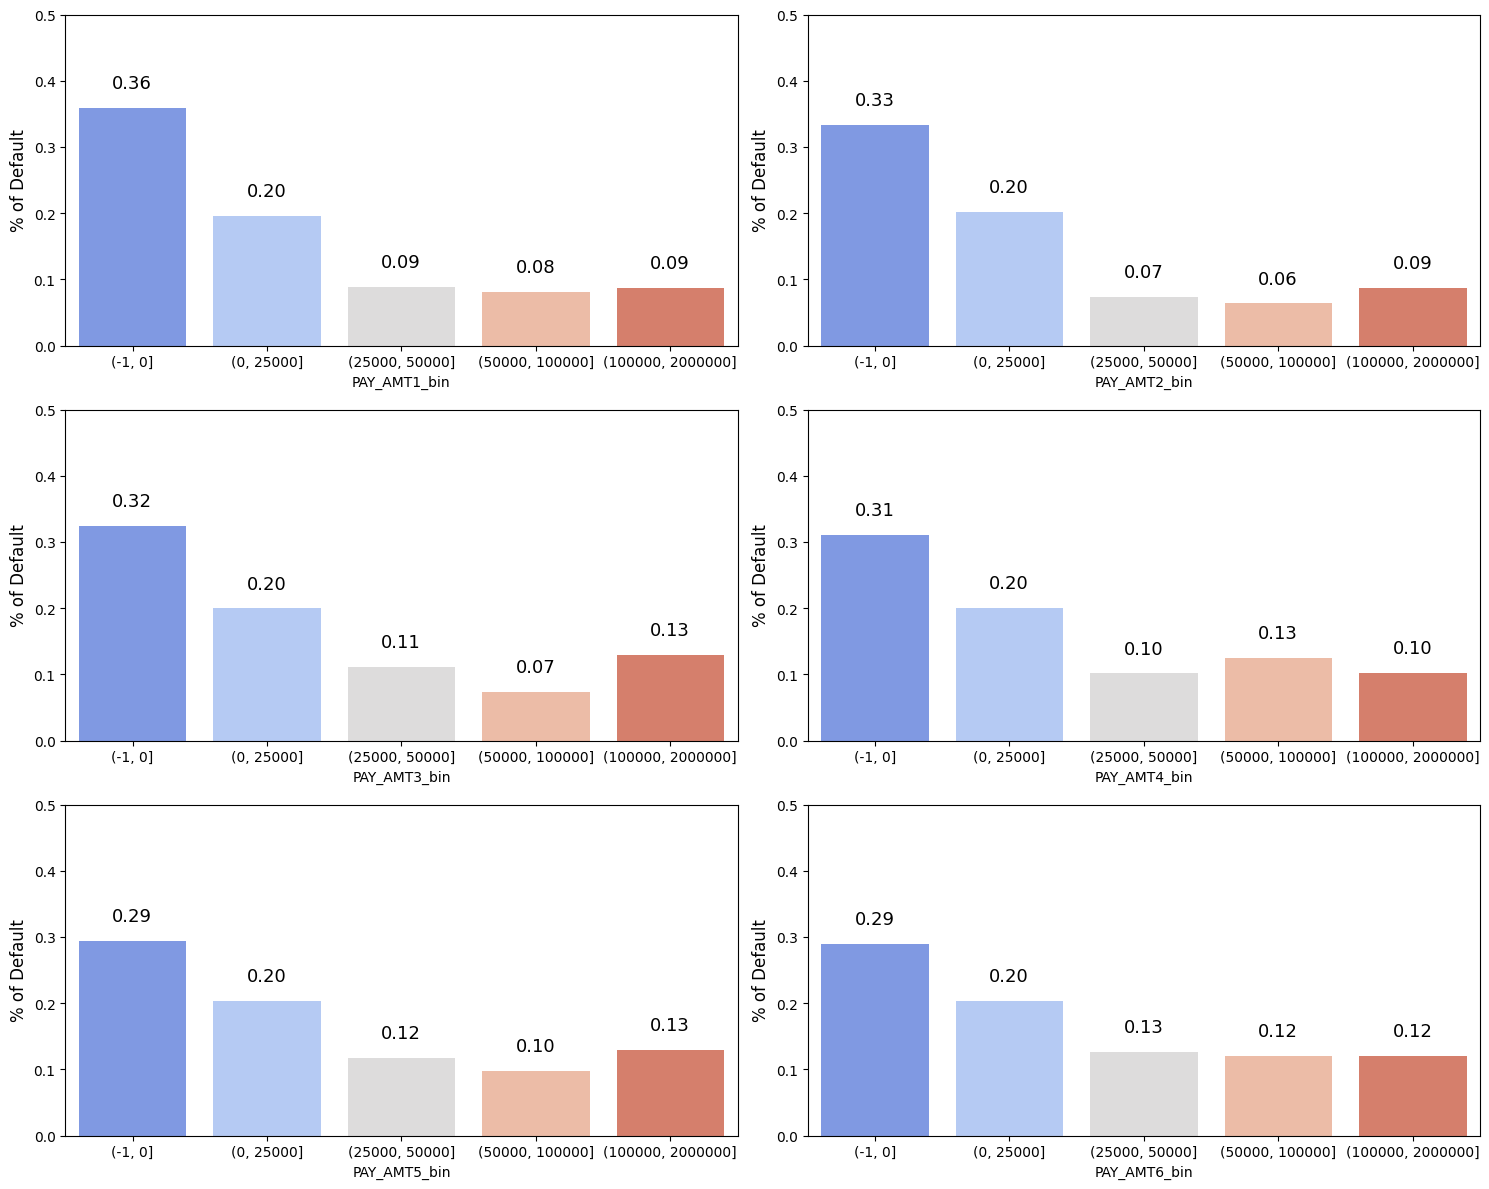

In [67]:
plt.figure(figsize=(15,12))

for i,col in enumerate(pay_amtx_bins):    
    plt.subplot(3,2,i + 1)
    ax = sns.barplot(x = col, y = "Default", data = df, palette = 'coolwarm', ci = None)
    plt.ylabel("% of Default", fontsize= 12)
    plt.ylim(0,0.5)
    plt.tight_layout()
    
    for p in ax.patches:
        ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.25, p.get_height()+0.03),fontsize=13)

plt.show()

# <a id="4">Creating and Evaluating Models</a> 

In [68]:
X = df.copy().drop('Default', axis = 1)
Y = df['Default']

In [69]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 44 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   ID             30000 non-null  int64   
 1   LIMIT_BAL      30000 non-null  float64 
 2   SEX            30000 non-null  int64   
 3   EDUCATION      30000 non-null  int64   
 4   MARRIAGE       30000 non-null  int64   
 5   AGE            30000 non-null  int64   
 6   PAY_1          30000 non-null  int64   
 7   PAY_2          30000 non-null  int64   
 8   PAY_3          30000 non-null  int64   
 9   PAY_4          30000 non-null  int64   
 10  PAY_5          30000 non-null  int64   
 11  PAY_6          30000 non-null  int64   
 12  BILL_AMT1      30000 non-null  float64 
 13  BILL_AMT2      30000 non-null  float64 
 14  BILL_AMT3      30000 non-null  float64 
 15  BILL_AMT4      30000 non-null  float64 
 16  BILL_AMT5      30000 non-null  float64 
 17  BILL_AMT6      30000 non-null  

In [70]:
X_base = X.copy().drop(pay_x_new, axis = 1)
X_base = X_base.drop(bill_amtx_bins, axis = 1)
X_base = X_base.drop(pay_amtx_bins, axis = 1)
X_base = X_base.drop(['AgeBin', 'LimitBin'], axis = 1)
X_base

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,2,120000.0,2,2,2,26,-1,2,0,0,...,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,3,90000.0,2,2,2,34,0,0,0,0,...,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,4,50000.0,2,2,1,37,0,0,0,0,...,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,208365.0,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,3502.0,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,2758.0,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,76304.0,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0


In [71]:
X_base_train, X_base_test, Y_train, Y_test = train_test_split(X_base, Y, test_size = 0.2, random_state = 42
                                                    , stratify = Y)

In [72]:
rf_model = RandomForestClassifier(random_state = 42)

rf_model.fit(X_base_train, Y_train)
pred_rf = rf_model.predict(X_base_test)

print("Test Accuracy: ",metrics.accuracy_score(Y_test, pred_rf))

Test Accuracy:  0.8105


The Random Forest yielded an accuracy of 81,35% which can look like a good score. However, if we remember the beginning of the EDA section, we recall that 77,9% of our samples are from one class (no default), which means that if our model assign '0' to every sample, it would reach a score close from what we have found. Let's plot the confusion matrix and the classification report to have a better understanding of the results.

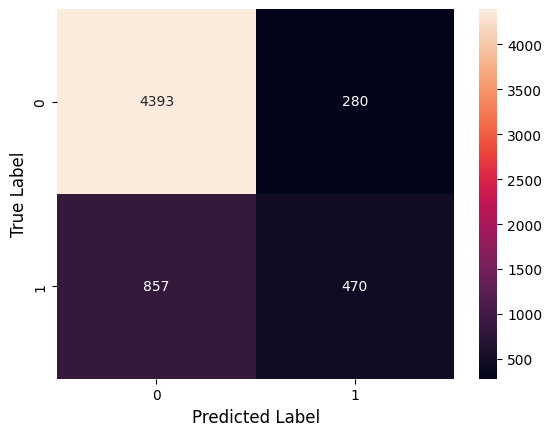

In [73]:
rf_confusion_matrix = metrics.confusion_matrix(Y_test, pred_rf)
sns.heatmap(rf_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [74]:
print(metrics.classification_report(Y_test, pred_rf, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4673
           1       0.63      0.35      0.45      1327

    accuracy                           0.81      6000
   macro avg       0.73      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000



It became clearer that perhaps accuracy is not the most appropriate metric to evaluate our models. Choosing the best metric depends a lot on the goals and the context that would lead to their use. We would need to know, for example, whether the financial impact of lending money to someone who will probably default is greater or less than the impact of losing potential customers because of a false negative. 

In this notebook, we will use the Area Under the Curve of Receiver Characteristic Operator (AUC-ROC or ROC-AUC) to assess the performance of our models. The ROC-AUC measures the ability of a model is to distinguish between classes

ROC_AUC:  0.7585600132622252


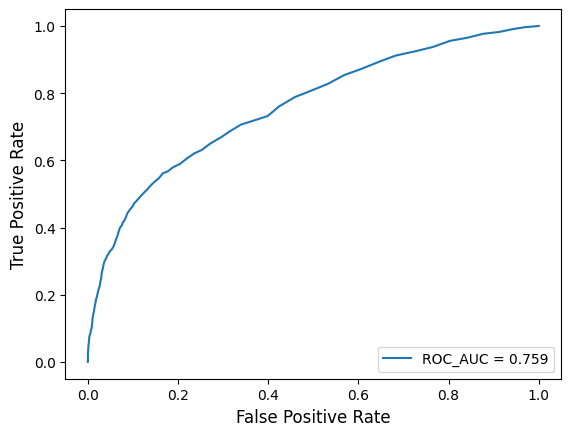

In [75]:
rf_pred_proba = rf_model.predict_proba(X_base_test)[:,1]

rf_roc_auc = metrics.roc_auc_score(Y_test, rf_pred_proba)
print('ROC_AUC: ', rf_roc_auc)

rf_fpr, rf_tpr, thresholds = metrics.roc_curve(Y_test, rf_pred_proba)

plt.plot(rf_fpr,rf_tpr, label = 'ROC_AUC = %0.3f' % rf_roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

In [76]:
categorical_ft_base = ['SEX', 'EDUCATION', 'MARRIAGE']

cat_model = CatBoostClassifier (random_state = 42, eval_metric = 'AUC')
cat_model.fit(X_base_train, Y_train, early_stopping_rounds = 100, eval_set = [(X_base_test,Y_test)], cat_features = categorical_ft_base)
pred_cat = cat_model.predict(X_base_test)

Learning rate set to 0.069474
0:	test: 0.7521430	best: 0.7521430 (0)	total: 95.1ms	remaining: 1m 34s
1:	test: 0.7574065	best: 0.7574065 (1)	total: 115ms	remaining: 57.2s
2:	test: 0.7600816	best: 0.7600816 (2)	total: 130ms	remaining: 43.4s
3:	test: 0.7615839	best: 0.7615839 (3)	total: 149ms	remaining: 37.1s
4:	test: 0.7649187	best: 0.7649187 (4)	total: 164ms	remaining: 32.6s
5:	test: 0.7632905	best: 0.7649187 (4)	total: 179ms	remaining: 29.6s
6:	test: 0.7637895	best: 0.7649187 (4)	total: 193ms	remaining: 27.3s
7:	test: 0.7631296	best: 0.7649187 (4)	total: 206ms	remaining: 25.6s
8:	test: 0.7641197	best: 0.7649187 (4)	total: 222ms	remaining: 24.4s
9:	test: 0.7640774	best: 0.7649187 (4)	total: 236ms	remaining: 23.4s
10:	test: 0.7659763	best: 0.7659763 (10)	total: 251ms	remaining: 22.5s
11:	test: 0.7658850	best: 0.7659763 (10)	total: 268ms	remaining: 22s
12:	test: 0.7653735	best: 0.7659763 (10)	total: 284ms	remaining: 21.6s
13:	test: 0.7650978	best: 0.7659763 (10)	total: 299ms	remaining: 21

In [77]:
print("Test Accuracy: ",metrics.accuracy_score(Y_test, pred_cat))

Test Accuracy:  0.8181666666666667


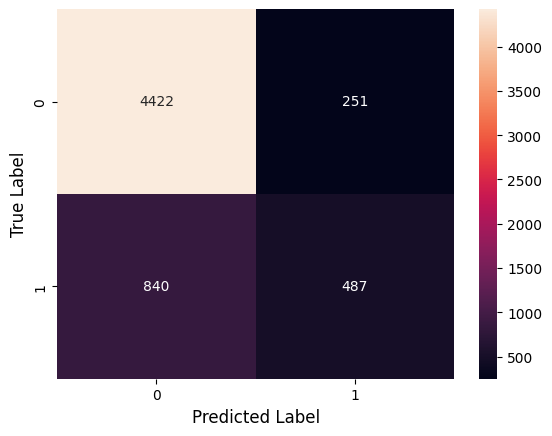

In [78]:
cat_confusion_matrix = metrics.confusion_matrix(Y_test, pred_cat)
sns.heatmap(cat_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [79]:
print(metrics.classification_report(Y_test, pred_cat, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.66      0.37      0.47      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000



ROC_AUC:  0.7809770280004857


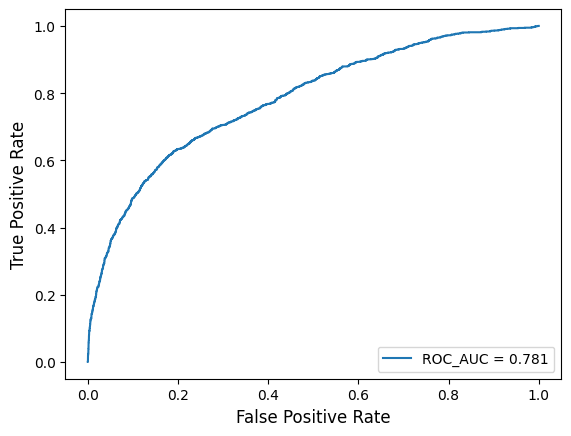

In [80]:
cat_pred_proba = cat_model.predict_proba(X_base_test)[:,1]

cat_roc_auc = metrics.roc_auc_score(Y_test, cat_pred_proba)
print('ROC_AUC: ', cat_roc_auc)

cat_fpr, cat_tpr, thresholds = metrics.roc_curve(Y_test, cat_pred_proba)

plt.plot(cat_fpr,cat_tpr, label = 'ROC_AUC = %0.3f' % cat_roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

In [81]:
X_NEW = X.copy()

In [82]:
pay_x_new.extend(bill_amtx_bins)

In [83]:
pay_x_new.extend(pay_amtx_bins)

In [84]:
pay_x_new.append('AgeBin')
pay_x_new.append('LimitBin')

In [85]:
le = LabelEncoder()

for col in pay_x_new:
    X_NEW[col] = le.fit_transform(X_NEW[col])

In [86]:
X_new_train, X_new_test, Y_train, Y_test = train_test_split(X_NEW, Y, test_size = 0.2, random_state = 42
                                                    , stratify = Y)

In [87]:
cat_col = pay_x_new.copy()

In [88]:
cat_col.extend(categorical_ft_base)

In [89]:
categorical_ft_base

['SEX', 'EDUCATION', 'MARRIAGE']

In [90]:
cat_model_new = CatBoostClassifier (random_state = 42, eval_metric = 'AUC')
cat_model_new.fit(X_new_train, Y_train, early_stopping_rounds = 100, eval_set = [(X_new_test,Y_test)], cat_features = cat_col)
pred_cat_new = cat_model_new.predict(X_new_test)

Learning rate set to 0.069474
0:	test: 0.7502981	best: 0.7502981 (0)	total: 38ms	remaining: 37.9s
1:	test: 0.7608798	best: 0.7608798 (1)	total: 56.8ms	remaining: 28.4s
2:	test: 0.7645938	best: 0.7645938 (2)	total: 80.9ms	remaining: 26.9s
3:	test: 0.7623949	best: 0.7645938 (2)	total: 101ms	remaining: 25.3s
4:	test: 0.7620030	best: 0.7645938 (2)	total: 122ms	remaining: 24.4s
5:	test: 0.7624043	best: 0.7645938 (2)	total: 142ms	remaining: 23.5s
6:	test: 0.7612881	best: 0.7645938 (2)	total: 160ms	remaining: 22.6s
7:	test: 0.7608897	best: 0.7645938 (2)	total: 184ms	remaining: 22.9s
8:	test: 0.7616034	best: 0.7645938 (2)	total: 211ms	remaining: 23.2s
9:	test: 0.7633501	best: 0.7645938 (2)	total: 240ms	remaining: 23.8s
10:	test: 0.7633427	best: 0.7645938 (2)	total: 267ms	remaining: 24s
11:	test: 0.7646621	best: 0.7646621 (11)	total: 305ms	remaining: 25.1s
12:	test: 0.7658944	best: 0.7658944 (12)	total: 329ms	remaining: 25s
13:	test: 0.7656554	best: 0.7658944 (12)	total: 351ms	remaining: 24.7s


In [91]:
print("Test Accuracy: ",metrics.accuracy_score(Y_test, pred_cat_new))

Test Accuracy:  0.8188333333333333


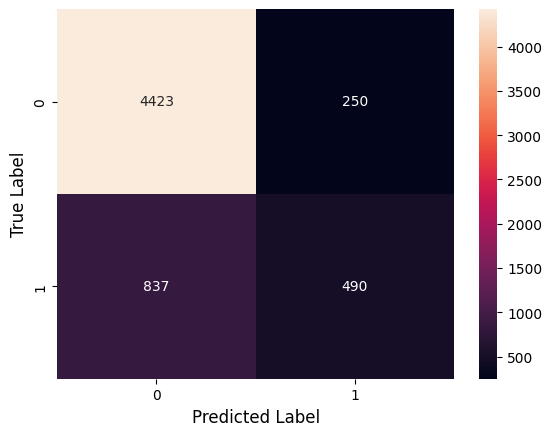

In [92]:
cat_new_confusion_matrix = metrics.confusion_matrix(Y_test, pred_cat_new)
sns.heatmap(cat_new_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

ROC_AUC:  0.7818797752839792


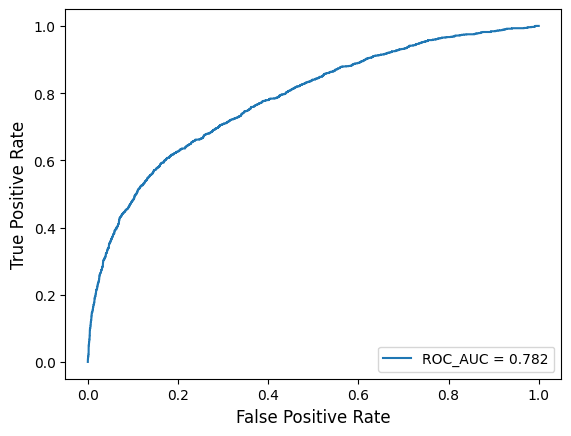

In [93]:
cat_new_pred_proba = cat_model_new.predict_proba(X_new_test)[:,1]

cat_new_roc_auc = metrics.roc_auc_score(Y_test, cat_new_pred_proba)
print('ROC_AUC: ', cat_new_roc_auc)

cat_new_fpr, cat_new_tpr, thresholds = metrics.roc_curve(Y_test, cat_new_pred_proba)

plt.plot(cat_new_fpr,cat_new_tpr, label = 'ROC_AUC = %0.3f' % cat_new_roc_auc)
plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

In [94]:
pool = Pool(X_new_train, Y_train, cat_features=cat_col)

Feature_importance = pd.DataFrame({'feature_importance': cat_model_new.get_feature_importance(pool), 
                      'feature_names': X_new_train.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

Feature_importance

,feature_importance,feature_names
6,10.155959,PAY_1
26,8.978990,PAY_1_new
1,6.417536,LIMIT_BAL
12,5.718729,BILL_AMT1
7,3.993835,PAY_2
13,3.663018,BILL_AMT2
19,3.634654,PAY_AMT2
0,3.324564,ID
3,3.155381,EDUCATION
20,2.989311,PAY_AMT3


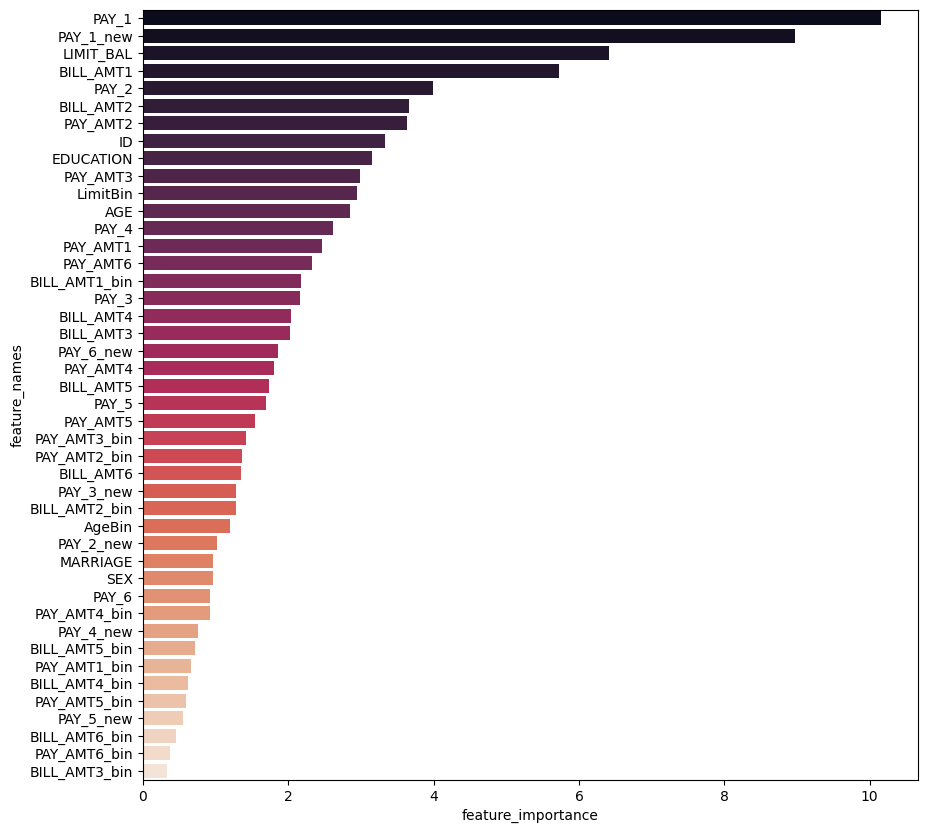

In [95]:
plt.figure(figsize=(10,10))

sns.barplot(x=Feature_importance['feature_importance'], y=Feature_importance['feature_names'], palette = 'rocket')

plt.show()

In [96]:
explainer = shap.TreeExplainer(cat_model_new)
shap_values = explainer.shap_values(pool)

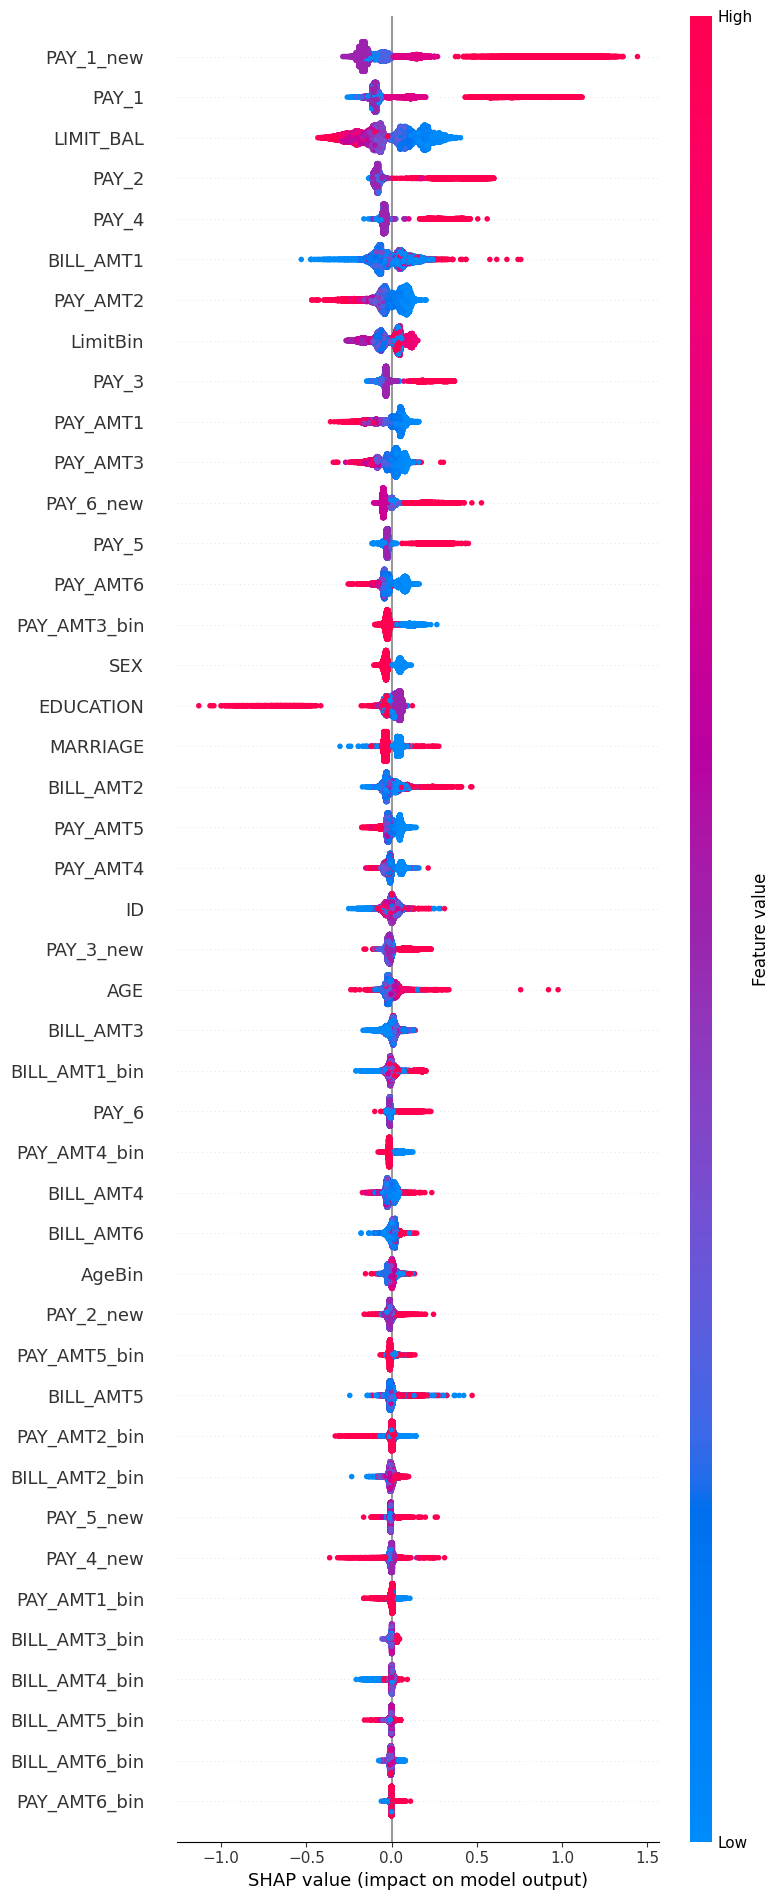

In [97]:
#max_display needed to show more than 20 features
shap.summary_plot(shap_values, X_new_train, max_display = len(X_new_train.columns))